In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : True,
    'left'          : True,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_1_1_e_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(701992, 828)
(701992, 1)
validation
(107232, 828)
(107232, 1)
test
(76096, 828)
(76096, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/71 [..............................] - ETA: 1:28 - loss: 0.0374 - STD: 2.4445e-04 - MAE: 0.1838

 4/71 [>.............................] - ETA: 1s - loss: 0.0280 - STD: 3.0947e-04 - MAE: 0.1247  

 5/71 [=>............................] - ETA: 2s - loss: 0.0277 - STD: 2.8082e-04 - MAE: 0.1222

 6/71 [=>............................] - ETA: 2s - loss: 0.0265 - STD: 2.6724e-04 - MAE: 0.1161

 7/71 [=>............................] - ETA: 2s - loss: 0.0249 - STD: 2.7186e-04 - MAE: 0.1091

 8/71 [==>...........................] - ETA: 2s - loss: 0.0237 - STD: 2.8958e-04 - MAE: 0.1063

 9/71 [==>...........................] - ETA: 2s - loss: 0.0230 - STD: 3.1391e-04 - MAE: 0.1069

10/71 [===>..........................] - ETA: 2s - loss: 0.0227 - STD: 3.4121e-04 - MAE: 0.1089

11/71 [===>..........................] - ETA: 2s - loss: 0.0225 - STD: 3.6892e-04 - MAE: 0.1103

12/71 [====>.........................] - ETA: 2s - loss: 0.0221 - STD: 3.9531e-04 - MAE: 0.1103

13/71 [====>.........................] - ETA: 2s - loss: 0.0215 - STD: 4.1890e-04 - MAE: 0.1089

14/71 [====>.........................] - ETA: 2s - loss: 0.0210 - STD: 4.3991e-04 - MAE: 0.1066

15/71 [=====>........................] - ETA: 2s - loss: 0.0206 - STD: 4.5851e-04 - MAE: 0.1040

16/71 [=====>........................] - ETA: 2s - loss: 0.0203 - STD: 4.7509e-04 - MAE: 0.1018

17/71 [======>.......................] - ETA: 2s - loss: 0.0200 - STD: 4.9143e-04 - MAE: 0.0999

18/71 [======>.......................] - ETA: 2s - loss: 0.0199 - STD: 5.0796e-04 - MAE: 0.0983

19/71 [=======>......................] - ETA: 2s - loss: 0.0197 - STD: 5.2517e-04 - MAE: 0.0967

20/71 [=======>......................] - ETA: 3s - loss: 0.0196 - STD: 5.4572e-04 - MAE: 0.0953

24/71 [=========>....................] - ETA: 3s - loss: 0.0188 - STD: 6.4326e-04 - MAE: 0.0929

25/71 [=========>....................] - ETA: 3s - loss: 0.0186 - STD: 6.7128e-04 - MAE: 0.0929

26/71 [=========>....................] - ETA: 2s - loss: 0.0185 - STD: 6.9961e-04 - MAE: 0.0931

27/71 [==========>...................] - ETA: 2s - loss: 0.0183 - STD: 7.2772e-04 - MAE: 0.0930

28/71 [==========>...................] - ETA: 2s - loss: 0.0182 - STD: 7.5584e-04 - MAE: 0.0928

29/71 [===========>..................] - ETA: 2s - loss: 0.0180 - STD: 7.8361e-04 - MAE: 0.0925

30/71 [===========>..................] - ETA: 2s - loss: 0.0179 - STD: 8.1051e-04 - MAE: 0.0919

31/71 [============>.................] - ETA: 2s - loss: 0.0178 - STD: 8.3800e-04 - MAE: 0.0913

32/71 [============>.................] - ETA: 2s - loss: 0.0177 - STD: 8.6529e-04 - MAE: 0.0906

33/71 [============>.................] - ETA: 2s - loss: 0.0176 - STD: 8.9365e-04 - MAE: 0.0899

34/71 [=============>................] - ETA: 2s - loss: 0.0175 - STD: 9.2326e-04 - MAE: 0.0893

35/71 [=============>................] - ETA: 2s - loss: 0.0174 - STD: 9.5571e-04 - MAE: 0.0887

36/71 [==============>...............] - ETA: 2s - loss: 0.0173 - STD: 9.9073e-04 - MAE: 0.0882

37/71 [==============>...............] - ETA: 2s - loss: 0.0172 - STD: 0.0010 - MAE: 0.0878    

38/71 [===============>..............] - ETA: 2s - loss: 0.0171 - STD: 0.0011 - MAE: 0.0876

39/71 [===============>..............] - ETA: 2s - loss: 0.0171 - STD: 0.0011 - MAE: 0.0874

40/71 [===============>..............] - ETA: 1s - loss: 0.0170 - STD: 0.0012 - MAE: 0.0874

41/71 [================>.............] - ETA: 1s - loss: 0.0169 - STD: 0.0012 - MAE: 0.0873

42/71 [================>.............] - ETA: 1s - loss: 0.0168 - STD: 0.0013 - MAE: 0.0872

43/71 [=================>............] - ETA: 1s - loss: 0.0168 - STD: 0.0013 - MAE: 0.0871

44/71 [=================>............] - ETA: 1s - loss: 0.0167 - STD: 0.0014 - MAE: 0.0869

45/71 [==================>...........] - ETA: 1s - loss: 0.0166 - STD: 0.0014 - MAE: 0.0866

46/71 [==================>...........] - ETA: 1s - loss: 0.0166 - STD: 0.0015 - MAE: 0.0863

47/71 [==================>...........] - ETA: 1s - loss: 0.0165 - STD: 0.0016 - MAE: 0.0860

48/71 [===================>..........] - ETA: 1s - loss: 0.0164 - STD: 0.0017 - MAE: 0.0857

49/71 [===================>..........] - ETA: 1s - loss: 0.0164 - STD: 0.0017 - MAE: 0.0854

50/71 [====================>.........] - ETA: 1s - loss: 0.0163 - STD: 0.0018 - MAE: 0.0851

51/71 [====================>.........] - ETA: 1s - loss: 0.0163 - STD: 0.0019 - MAE: 0.0849

52/71 [====================>.........] - ETA: 1s - loss: 0.0162 - STD: 0.0020 - MAE: 0.0847

53/71 [=====================>........] - ETA: 1s - loss: 0.0162 - STD: 0.0022 - MAE: 0.0845

54/71 [=====================>........] - ETA: 1s - loss: 0.0161 - STD: 0.0023 - MAE: 0.0844

55/71 [======================>.......] - ETA: 0s - loss: 0.0161 - STD: 0.0024 - MAE: 0.0843

56/71 [======================>.......] - ETA: 0s - loss: 0.0160 - STD: 0.0026 - MAE: 0.0841

57/71 [=======================>......] - ETA: 0s - loss: 0.0159 - STD: 0.0028 - MAE: 0.0840

58/71 [=======================>......] - ETA: 0s - loss: 0.0159 - STD: 0.0029 - MAE: 0.0838

59/71 [=======================>......] - ETA: 0s - loss: 0.0158 - STD: 0.0031 - MAE: 0.0836

60/71 [========================>.....] - ETA: 0s - loss: 0.0157 - STD: 0.0034 - MAE: 0.0833

61/71 [========================>.....] - ETA: 0s - loss: 0.0157 - STD: 0.0036 - MAE: 0.0830

62/71 [=========================>....] - ETA: 0s - loss: 0.0156 - STD: 0.0039 - MAE: 0.0828

63/71 [=========================>....] - ETA: 0s - loss: 0.0155 - STD: 0.0042 - MAE: 0.0825

64/71 [==========================>...] - ETA: 0s - loss: 0.0155 - STD: 0.0045 - MAE: 0.0823

65/71 [==========================>...] - ETA: 0s - loss: 0.0154 - STD: 0.0049 - MAE: 0.0820

66/71 [==========================>...] - ETA: 0s - loss: 0.0153 - STD: 0.0053 - MAE: 0.0818

67/71 [===========================>..] - ETA: 0s - loss: 0.0152 - STD: 0.0058 - MAE: 0.0815

68/71 [===========================>..] - ETA: 0s - loss: 0.0152 - STD: 0.0063 - MAE: 0.0813

69/71 [============================>.] - ETA: 0s - loss: 0.0151 - STD: 0.0068 - MAE: 0.0809

70/71 [============================>.] - ETA: 0s - loss: 0.0150 - STD: 0.0074 - MAE: 0.0806

71/71 [==============================] - ETA: 0s - loss: 0.0149 - STD: 0.0080 - MAE: 0.0803

71/71 [==============================] - 6s 70ms/step - loss: 0.0149 - STD: 0.0080 - MAE: 0.0803 - val_loss: 0.0085 - val_STD: 0.0495 - val_MAE: 0.0563


Epoch 2/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0083 - STD: 0.0582 - MAE: 0.0572

 2/71 [..............................] - ETA: 4s - loss: 0.0079 - STD: 0.0613 - MAE: 0.0568

 3/71 [>.............................] - ETA: 4s - loss: 0.0076 - STD: 0.0639 - MAE: 0.0559

 4/71 [>.............................] - ETA: 4s - loss: 0.0073 - STD: 0.0662 - MAE: 0.0554

 5/71 [=>............................] - ETA: 4s - loss: 0.0072 - STD: 0.0681 - MAE: 0.0549

 6/71 [=>............................] - ETA: 3s - loss: 0.0070 - STD: 0.0699 - MAE: 0.0542

 7/71 [=>............................] - ETA: 3s - loss: 0.0068 - STD: 0.0718 - MAE: 0.0537

 8/71 [==>...........................] - ETA: 3s - loss: 0.0067 - STD: 0.0737 - MAE: 0.0532

 9/71 [==>...........................] - ETA: 3s - loss: 0.0065 - STD: 0.0754 - MAE: 0.0527

10/71 [===>..........................] - ETA: 3s - loss: 0.0064 - STD: 0.0770 - MAE: 0.0522

11/71 [===>..........................] - ETA: 3s - loss: 0.0062 - STD: 0.0784 - MAE: 0.0517

12/71 [====>.........................] - ETA: 3s - loss: 0.0061 - STD: 0.0792 - MAE: 0.0512

13/71 [====>.........................] - ETA: 3s - loss: 0.0060 - STD: 0.0803 - MAE: 0.0507

14/71 [====>.........................] - ETA: 3s - loss: 0.0059 - STD: 0.0814 - MAE: 0.0503

15/71 [=====>........................] - ETA: 3s - loss: 0.0058 - STD: 0.0824 - MAE: 0.0499

16/71 [=====>........................] - ETA: 3s - loss: 0.0057 - STD: 0.0832 - MAE: 0.0495

17/71 [======>.......................] - ETA: 3s - loss: 0.0057 - STD: 0.0838 - MAE: 0.0492

18/71 [======>.......................] - ETA: 3s - loss: 0.0056 - STD: 0.0845 - MAE: 0.0488

19/71 [=======>......................] - ETA: 3s - loss: 0.0055 - STD: 0.0854 - MAE: 0.0485

20/71 [=======>......................] - ETA: 3s - loss: 0.0055 - STD: 0.0864 - MAE: 0.0482

21/71 [=======>......................] - ETA: 2s - loss: 0.0054 - STD: 0.0873 - MAE: 0.0480

22/71 [========>.....................] - ETA: 2s - loss: 0.0054 - STD: 0.0879 - MAE: 0.0478

23/71 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0884 - MAE: 0.0475

25/71 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.0896 - MAE: 0.0470

26/71 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0903 - MAE: 0.0468

27/71 [==========>...................] - ETA: 2s - loss: 0.0052 - STD: 0.0908 - MAE: 0.0466

28/71 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0910 - MAE: 0.0465

29/71 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0913 - MAE: 0.0463

30/71 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0918 - MAE: 0.0462

31/71 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0924 - MAE: 0.0460

32/71 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0927 - MAE: 0.0459

33/71 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0929 - MAE: 0.0457

34/71 [=============>................] - ETA: 2s - loss: 0.0050 - STD: 0.0931 - MAE: 0.0456

35/71 [=============>................] - ETA: 2s - loss: 0.0049 - STD: 0.0933 - MAE: 0.0455

36/71 [==============>...............] - ETA: 2s - loss: 0.0049 - STD: 0.0937 - MAE: 0.0454

37/71 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0941 - MAE: 0.0453

38/71 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0942 - MAE: 0.0452

39/71 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0942 - MAE: 0.0450

40/71 [===============>..............] - ETA: 1s - loss: 0.0048 - STD: 0.0942 - MAE: 0.0449

41/71 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0944 - MAE: 0.0448

42/71 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0947 - MAE: 0.0447

43/71 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0949 - MAE: 0.0446

44/71 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0950 - MAE: 0.0446

45/71 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0951 - MAE: 0.0445

46/71 [==================>...........] - ETA: 1s - loss: 0.0047 - STD: 0.0952 - MAE: 0.0444

47/71 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0954 - MAE: 0.0443

48/71 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0956 - MAE: 0.0442

49/71 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0958 - MAE: 0.0441

50/71 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0958 - MAE: 0.0441

51/71 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0959 - MAE: 0.0440

52/71 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0960 - MAE: 0.0439

53/71 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0962 - MAE: 0.0439

54/71 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0964 - MAE: 0.0438

55/71 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0964 - MAE: 0.0438

56/71 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0965 - MAE: 0.0437

57/71 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0966 - MAE: 0.0436

58/71 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0968 - MAE: 0.0436

59/71 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0969 - MAE: 0.0435

60/71 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0970 - MAE: 0.0434

61/71 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0971 - MAE: 0.0434

62/71 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0972 - MAE: 0.0433

63/71 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0973 - MAE: 0.0433

64/71 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0974 - MAE: 0.0432

65/71 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0975 - MAE: 0.0431

66/71 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0975 - MAE: 0.0431

67/71 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0976 - MAE: 0.0430

68/71 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0977 - MAE: 0.0430

69/71 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0978 - MAE: 0.0429

70/71 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0979 - MAE: 0.0429

71/71 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0980 - MAE: 0.0428

71/71 [==============================] - 4s 61ms/step - loss: 0.0043 - STD: 0.0980 - MAE: 0.0428 - val_loss: 0.0046 - val_STD: 0.0905 - val_MAE: 0.0444


Epoch 3/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0994 - MAE: 0.0387

 2/71 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.1009 - MAE: 0.0389

 3/71 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.1009 - MAE: 0.0386

 4/71 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.1017 - MAE: 0.0387

 5/71 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.1022 - MAE: 0.0388

 6/71 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.1021 - MAE: 0.0388

 7/71 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.1024 - MAE: 0.0387

 8/71 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.1030 - MAE: 0.0388

 9/71 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.1032 - MAE: 0.0389

10/71 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.1033 - MAE: 0.0388

11/71 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.1033 - MAE: 0.0389

12/71 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.1032 - MAE: 0.0389

13/71 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.1033 - MAE: 0.0388

14/71 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.1033 - MAE: 0.0388

15/71 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.1033 - MAE: 0.0388

16/71 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.1035 - MAE: 0.0388

17/71 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.1038 - MAE: 0.0388

18/71 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.1037 - MAE: 0.0388

19/71 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.1035 - MAE: 0.0388

20/71 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.1035 - MAE: 0.0387

21/71 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.1035 - MAE: 0.0387

22/71 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.1033 - MAE: 0.0387

23/71 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.1033 - MAE: 0.0387

24/71 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.1033 - MAE: 0.0387

25/71 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.1034 - MAE: 0.0387

26/71 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.1034 - MAE: 0.0386

27/71 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.1033 - MAE: 0.0386

28/71 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.1035 - MAE: 0.0386

29/71 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.1035 - MAE: 0.0386

30/71 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.1036 - MAE: 0.0386

31/71 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.1036 - MAE: 0.0386

32/71 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.1037 - MAE: 0.0386

33/71 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.1038 - MAE: 0.0385

34/71 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.1037 - MAE: 0.0385

35/71 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.1038 - MAE: 0.0385

36/71 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.1039 - MAE: 0.0385

37/71 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.1039 - MAE: 0.0385

38/71 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.1039 - MAE: 0.0385

39/71 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.1039 - MAE: 0.0385

40/71 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.1040 - MAE: 0.0385

41/71 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.1040 - MAE: 0.0385

42/71 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.1040 - MAE: 0.0384

43/71 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.1040 - MAE: 0.0384

44/71 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.1041 - MAE: 0.0384

45/71 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.1041 - MAE: 0.0384

46/71 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.1041 - MAE: 0.0384

47/71 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.1041 - MAE: 0.0383

48/71 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.1041 - MAE: 0.0383

49/71 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.1041 - MAE: 0.0383

50/71 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.1041 - MAE: 0.0383

51/71 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.1041 - MAE: 0.0382

52/71 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.1041 - MAE: 0.0382

53/71 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.1041 - MAE: 0.0382

54/71 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.1041 - MAE: 0.0382

55/71 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.1041 - MAE: 0.0382

56/71 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.1041 - MAE: 0.0382

58/71 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.1040 - MAE: 0.0381

59/71 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.1041 - MAE: 0.0381

60/71 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.1040 - MAE: 0.0381

61/71 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.1040 - MAE: 0.0381

62/71 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.1041 - MAE: 0.0381

63/71 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.1041 - MAE: 0.0380

64/71 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.1041 - MAE: 0.0380

65/71 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.1041 - MAE: 0.0380

66/71 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.1041 - MAE: 0.0380

67/71 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.1041 - MAE: 0.0380

68/71 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.1041 - MAE: 0.0380

69/71 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.1042 - MAE: 0.0380

70/71 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.1041 - MAE: 0.0379

71/71 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.1042 - MAE: 0.0379

71/71 [==============================] - 5s 63ms/step - loss: 0.0033 - STD: 0.1042 - MAE: 0.0379 - val_loss: 0.0046 - val_STD: 0.0931 - val_MAE: 0.0441


Epoch 4/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.1052 - MAE: 0.0363

 2/71 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.1056 - MAE: 0.0367

 3/71 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.1046 - MAE: 0.0367

 4/71 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.1046 - MAE: 0.0365

 5/71 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.1048 - MAE: 0.0366

 6/71 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.1044 - MAE: 0.0365

 7/71 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.1044 - MAE: 0.0365

 8/71 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.1049 - MAE: 0.0365

 9/71 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.1048 - MAE: 0.0365

10/71 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.1046 - MAE: 0.0365

11/71 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.1049 - MAE: 0.0365

12/71 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.1047 - MAE: 0.0365

13/71 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.1043 - MAE: 0.0365

14/71 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.1046 - MAE: 0.0365

15/71 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.1048 - MAE: 0.0366

16/71 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.1046 - MAE: 0.0365

17/71 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.1046 - MAE: 0.0365

18/71 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.1045 - MAE: 0.0365

19/71 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.1046 - MAE: 0.0365

20/71 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.1046 - MAE: 0.0365

21/71 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.1047 - MAE: 0.0365

22/71 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.1048 - MAE: 0.0365

23/71 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.1047 - MAE: 0.0365

24/71 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.1047 - MAE: 0.0364

25/71 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.1048 - MAE: 0.0364

26/71 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.1048 - MAE: 0.0364

28/71 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.1048 - MAE: 0.0364

29/71 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.1048 - MAE: 0.0364

30/71 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.1048 - MAE: 0.0364

31/71 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.1049 - MAE: 0.0364

32/71 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.1049 - MAE: 0.0364

33/71 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.1052 - MAE: 0.0364

34/71 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.1050 - MAE: 0.0364

35/71 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.1050 - MAE: 0.0364

36/71 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.1050 - MAE: 0.0364

37/71 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.1049 - MAE: 0.0364

38/71 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.1050 - MAE: 0.0364

39/71 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.1050 - MAE: 0.0364

40/71 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.1050 - MAE: 0.0364

41/71 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.1051 - MAE: 0.0364

42/71 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.1052 - MAE: 0.0364

43/71 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.1052 - MAE: 0.0364

44/71 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.1052 - MAE: 0.0364

45/71 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.1051 - MAE: 0.0363

46/71 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.1051 - MAE: 0.0363

47/71 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.1051 - MAE: 0.0363

48/71 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.1051 - MAE: 0.0363

49/71 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.1051 - MAE: 0.0363

50/71 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.1052 - MAE: 0.0363

51/71 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.1052 - MAE: 0.0363

52/71 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.1053 - MAE: 0.0363

53/71 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.1053 - MAE: 0.0362

54/71 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.1053 - MAE: 0.0362

55/71 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.1053 - MAE: 0.0362

56/71 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.1054 - MAE: 0.0362

57/71 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.1054 - MAE: 0.0362

58/71 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.1054 - MAE: 0.0361

59/71 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.1055 - MAE: 0.0361

60/71 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.1054 - MAE: 0.0361

61/71 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.1054 - MAE: 0.0361

62/71 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.1055 - MAE: 0.0361

63/71 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.1054 - MAE: 0.0361

64/71 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.1054 - MAE: 0.0361

65/71 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.1054 - MAE: 0.0361

66/71 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.1055 - MAE: 0.0362

67/71 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.1055 - MAE: 0.0362

68/71 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.1055 - MAE: 0.0361

69/71 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.1055 - MAE: 0.0361

70/71 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.1055 - MAE: 0.0361

71/71 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.1056 - MAE: 0.0361

71/71 [==============================] - 4s 62ms/step - loss: 0.0030 - STD: 0.1056 - MAE: 0.0361 - val_loss: 0.0040 - val_STD: 0.0955 - val_MAE: 0.0417


Epoch 5/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.1070 - MAE: 0.0355

 2/71 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.1048 - MAE: 0.0351

 3/71 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.1056 - MAE: 0.0355

 4/71 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.1056 - MAE: 0.0354

 5/71 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.1053 - MAE: 0.0352

 6/71 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.1060 - MAE: 0.0353

 7/71 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.1058 - MAE: 0.0352

 8/71 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.1057 - MAE: 0.0351

 9/71 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.1058 - MAE: 0.0352

10/71 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.1059 - MAE: 0.0352

11/71 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.1060 - MAE: 0.0351

12/71 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.1064 - MAE: 0.0351

13/71 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.1064 - MAE: 0.0351

14/71 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.1065 - MAE: 0.0351

15/71 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.1064 - MAE: 0.0351

16/71 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.1063 - MAE: 0.0350

17/71 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.1061 - MAE: 0.0350

18/71 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.1061 - MAE: 0.0350

19/71 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.1061 - MAE: 0.0350

20/71 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.1062 - MAE: 0.0350

21/71 [=======>......................] - ETA: 2s - loss: 0.0029 - STD: 0.1062 - MAE: 0.0350

22/71 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.1064 - MAE: 0.0350

23/71 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.1062 - MAE: 0.0350

24/71 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.1063 - MAE: 0.0350

25/71 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.1062 - MAE: 0.0350

26/71 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.1062 - MAE: 0.0350

27/71 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.1063 - MAE: 0.0350

28/71 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.1064 - MAE: 0.0350

29/71 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.1065 - MAE: 0.0350

30/71 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.1065 - MAE: 0.0349

31/71 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.1066 - MAE: 0.0349

32/71 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.1066 - MAE: 0.0349

34/71 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.1065 - MAE: 0.0351

35/71 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.1063 - MAE: 0.0351

36/71 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.1064 - MAE: 0.0354

37/71 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.1062 - MAE: 0.0354

38/71 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.1064 - MAE: 0.0355

39/71 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.1065 - MAE: 0.0354

40/71 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.1064 - MAE: 0.0354

41/71 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.1064 - MAE: 0.0355

42/71 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.1063 - MAE: 0.0355

43/71 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.1063 - MAE: 0.0355

44/71 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.1064 - MAE: 0.0355

45/71 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.1063 - MAE: 0.0355

46/71 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.1064 - MAE: 0.0355

47/71 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.1065 - MAE: 0.0355

48/71 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.1065 - MAE: 0.0355

49/71 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.1066 - MAE: 0.0354

50/71 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.1066 - MAE: 0.0354

51/71 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.1066 - MAE: 0.0354

52/71 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.1065 - MAE: 0.0354

53/71 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.1066 - MAE: 0.0354

54/71 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.1066 - MAE: 0.0354

55/71 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.1066 - MAE: 0.0353

56/71 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.1066 - MAE: 0.0353

57/71 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.1066 - MAE: 0.0353

58/71 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.1066 - MAE: 0.0353

59/71 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.1066 - MAE: 0.0353

60/71 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.1066 - MAE: 0.0353

61/71 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.1066 - MAE: 0.0353

62/71 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1066 - MAE: 0.0353

63/71 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.1066 - MAE: 0.0353

64/71 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.1067 - MAE: 0.0353

65/71 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.1066 - MAE: 0.0353

66/71 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.1066 - MAE: 0.0353

67/71 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1067 - MAE: 0.0353

68/71 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1066 - MAE: 0.0353

69/71 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.1066 - MAE: 0.0353

70/71 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.1065 - MAE: 0.0353

71/71 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.1065 - MAE: 0.0353

71/71 [==============================] - 4s 62ms/step - loss: 0.0029 - STD: 0.1065 - MAE: 0.0353 - val_loss: 0.0038 - val_STD: 0.0952 - val_MAE: 0.0414


Epoch 6/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.1096 - MAE: 0.0360

 2/71 [..............................] - ETA: 3s - loss: 0.0027 - STD: 0.1068 - MAE: 0.0350

 3/71 [>.............................] - ETA: 3s - loss: 0.0027 - STD: 0.1073 - MAE: 0.0349

 4/71 [>.............................] - ETA: 3s - loss: 0.0027 - STD: 0.1082 - MAE: 0.0348

 5/71 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.1078 - MAE: 0.0348

 6/71 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.1081 - MAE: 0.0349

 7/71 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.1081 - MAE: 0.0348

 8/71 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.1077 - MAE: 0.0348

 9/71 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.1081 - MAE: 0.0350

10/71 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.1077 - MAE: 0.0349

11/71 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.1077 - MAE: 0.0348

12/71 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.1078 - MAE: 0.0349

13/71 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.1073 - MAE: 0.0349

14/71 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.1075 - MAE: 0.0350

15/71 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.1072 - MAE: 0.0349

16/71 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.1071 - MAE: 0.0349

17/71 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.1073 - MAE: 0.0350

18/71 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.1072 - MAE: 0.0350

19/71 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.1073 - MAE: 0.0350

20/71 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.1073 - MAE: 0.0350

21/71 [=======>......................] - ETA: 2s - loss: 0.0028 - STD: 0.1070 - MAE: 0.0351

22/71 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.1072 - MAE: 0.0352

23/71 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.1071 - MAE: 0.0351

24/71 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.1070 - MAE: 0.0351

25/71 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.1073 - MAE: 0.0352

26/71 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.1071 - MAE: 0.0352

27/71 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.1072 - MAE: 0.0352

28/71 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.1072 - MAE: 0.0352

29/71 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.1070 - MAE: 0.0351

30/71 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.1070 - MAE: 0.0351

31/71 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.1069 - MAE: 0.0351

32/71 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.1068 - MAE: 0.0350

33/71 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.1070 - MAE: 0.0351

34/71 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.1070 - MAE: 0.0351

35/71 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.1070 - MAE: 0.0350

36/71 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.1070 - MAE: 0.0350

37/71 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.1070 - MAE: 0.0350

38/71 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.1071 - MAE: 0.0350

39/71 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.1071 - MAE: 0.0350

40/71 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.1070 - MAE: 0.0349

41/71 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.1070 - MAE: 0.0349

42/71 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.1070 - MAE: 0.0349

43/71 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.1070 - MAE: 0.0349

44/71 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.1070 - MAE: 0.0349

45/71 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.1071 - MAE: 0.0348

46/71 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.1070 - MAE: 0.0348

47/71 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.1071 - MAE: 0.0348

48/71 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.1071 - MAE: 0.0348

49/71 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.1072 - MAE: 0.0348

50/71 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.1072 - MAE: 0.0348

51/71 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.1072 - MAE: 0.0348

52/71 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.1072 - MAE: 0.0348

53/71 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.1072 - MAE: 0.0348

54/71 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.1072 - MAE: 0.0348

55/71 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.1072 - MAE: 0.0347

56/71 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.1072 - MAE: 0.0347

57/71 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.1072 - MAE: 0.0347

58/71 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.1072 - MAE: 0.0347

59/71 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.1071 - MAE: 0.0347

60/71 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.1071 - MAE: 0.0347

61/71 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.1070 - MAE: 0.0346

62/71 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.1071 - MAE: 0.0346

63/71 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.1071 - MAE: 0.0346

65/71 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.1071 - MAE: 0.0346

66/71 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.1072 - MAE: 0.0346

67/71 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.1071 - MAE: 0.0346

68/71 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.1071 - MAE: 0.0346

69/71 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.1070 - MAE: 0.0346

70/71 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.1071 - MAE: 0.0346

71/71 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.1071 - MAE: 0.0346

71/71 [==============================] - 4s 62ms/step - loss: 0.0028 - STD: 0.1071 - MAE: 0.0346 - val_loss: 0.0037 - val_STD: 0.0944 - val_MAE: 0.0391


Epoch 7/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0026 - STD: 0.1069 - MAE: 0.0338

 2/71 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.1076 - MAE: 0.0338

 3/71 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.1090 - MAE: 0.0344

 4/71 [>.............................] - ETA: 3s - loss: 0.0027 - STD: 0.1074 - MAE: 0.0343

 5/71 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.1084 - MAE: 0.0347

 6/71 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.1084 - MAE: 0.0345

 7/71 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.1081 - MAE: 0.0344

 8/71 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.1087 - MAE: 0.0345

 9/71 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.1081 - MAE: 0.0347

10/71 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.1082 - MAE: 0.0349

11/71 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.1080 - MAE: 0.0348

12/71 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.1080 - MAE: 0.0347

13/71 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.1080 - MAE: 0.0345

14/71 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.1080 - MAE: 0.0345

15/71 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.1082 - MAE: 0.0345

16/71 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.1080 - MAE: 0.0345

17/71 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.1081 - MAE: 0.0345

18/71 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.1079 - MAE: 0.0345

19/71 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.1078 - MAE: 0.0344

20/71 [=======>......................] - ETA: 2s - loss: 0.0027 - STD: 0.1080 - MAE: 0.0344

21/71 [=======>......................] - ETA: 2s - loss: 0.0027 - STD: 0.1080 - MAE: 0.0344

22/71 [========>.....................] - ETA: 2s - loss: 0.0027 - STD: 0.1080 - MAE: 0.0343

23/71 [========>.....................] - ETA: 2s - loss: 0.0027 - STD: 0.1079 - MAE: 0.0343

24/71 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.1079 - MAE: 0.0343

25/71 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.1079 - MAE: 0.0343

26/71 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.1080 - MAE: 0.0343

27/71 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.1080 - MAE: 0.0343

28/71 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.1081 - MAE: 0.0343

29/71 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.1080 - MAE: 0.0343

30/71 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.1078 - MAE: 0.0343

31/71 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.1079 - MAE: 0.0343

32/71 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.1078 - MAE: 0.0343

33/71 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.1079 - MAE: 0.0343

34/71 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.1079 - MAE: 0.0343

35/71 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.1080 - MAE: 0.0343

36/71 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.1080 - MAE: 0.0343

37/71 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.1080 - MAE: 0.0342

38/71 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.1079 - MAE: 0.0342

39/71 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.1079 - MAE: 0.0342

40/71 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.1079 - MAE: 0.0342

41/71 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.1078 - MAE: 0.0342

42/71 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.1079 - MAE: 0.0342

43/71 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.1077 - MAE: 0.0342

44/71 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.1079 - MAE: 0.0342

45/71 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.1077 - MAE: 0.0343

46/71 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.1078 - MAE: 0.0343

47/71 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.1077 - MAE: 0.0343

48/71 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.1077 - MAE: 0.0343

49/71 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.1078 - MAE: 0.0343

51/71 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.1078 - MAE: 0.0343

52/71 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.1078 - MAE: 0.0343

53/71 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1078 - MAE: 0.0343

54/71 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1078 - MAE: 0.0343

55/71 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.1078 - MAE: 0.0343

56/71 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.1078 - MAE: 0.0343

57/71 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1078 - MAE: 0.0343

58/71 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1078 - MAE: 0.0343

59/71 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1077 - MAE: 0.0342

60/71 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1078 - MAE: 0.0342

61/71 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1077 - MAE: 0.0342

62/71 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1078 - MAE: 0.0343

63/71 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1077 - MAE: 0.0343

64/71 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1077 - MAE: 0.0343

65/71 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1077 - MAE: 0.0343

66/71 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1077 - MAE: 0.0342

67/71 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1076 - MAE: 0.0342

68/71 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1077 - MAE: 0.0342

69/71 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1076 - MAE: 0.0342

70/71 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1077 - MAE: 0.0342

71/71 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1077 - MAE: 0.0342

71/71 [==============================] - 4s 58ms/step - loss: 0.0027 - STD: 0.1077 - MAE: 0.0342 - val_loss: 0.0036 - val_STD: 0.0941 - val_MAE: 0.0381


Epoch 8/10000


 1/71 [..............................] - ETA: 5s - loss: 0.0026 - STD: 0.1056 - MAE: 0.0333

 2/71 [..............................] - ETA: 3s - loss: 0.0026 - STD: 0.1088 - MAE: 0.0340

 3/71 [>.............................] - ETA: 3s - loss: 0.0027 - STD: 0.1063 - MAE: 0.0339

 4/71 [>.............................] - ETA: 3s - loss: 0.0028 - STD: 0.1081 - MAE: 0.0347

 5/71 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.1069 - MAE: 0.0343

 6/71 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.1071 - MAE: 0.0342

 7/71 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.1069 - MAE: 0.0341

 8/71 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.1067 - MAE: 0.0341

 9/71 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.1068 - MAE: 0.0342

10/71 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.1068 - MAE: 0.0341

11/71 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.1069 - MAE: 0.0341

12/71 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.1067 - MAE: 0.0340

13/71 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.1067 - MAE: 0.0340

14/71 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.1071 - MAE: 0.0341

15/71 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.1069 - MAE: 0.0341

16/71 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.1072 - MAE: 0.0342

17/71 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.1072 - MAE: 0.0343

18/71 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.1074 - MAE: 0.0344

19/71 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.1072 - MAE: 0.0345

20/71 [=======>......................] - ETA: 2s - loss: 0.0027 - STD: 0.1074 - MAE: 0.0346

21/71 [=======>......................] - ETA: 2s - loss: 0.0027 - STD: 0.1073 - MAE: 0.0345

22/71 [========>.....................] - ETA: 2s - loss: 0.0027 - STD: 0.1073 - MAE: 0.0345

23/71 [========>.....................] - ETA: 2s - loss: 0.0027 - STD: 0.1074 - MAE: 0.0345

24/71 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.1072 - MAE: 0.0344

25/71 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.1073 - MAE: 0.0344

26/71 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.1074 - MAE: 0.0344

27/71 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.1073 - MAE: 0.0344

28/71 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.1075 - MAE: 0.0344

29/71 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.1074 - MAE: 0.0344

30/71 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.1075 - MAE: 0.0343

31/71 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.1076 - MAE: 0.0343

32/71 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.1074 - MAE: 0.0343

33/71 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.1075 - MAE: 0.0343

34/71 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.1075 - MAE: 0.0343

35/71 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.1076 - MAE: 0.0343

36/71 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.1076 - MAE: 0.0342

37/71 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.1076 - MAE: 0.0342

38/71 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.1077 - MAE: 0.0343

39/71 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.1077 - MAE: 0.0342

41/71 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.1078 - MAE: 0.0342

42/71 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.1078 - MAE: 0.0342

43/71 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.1077 - MAE: 0.0342

44/71 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.1076 - MAE: 0.0342

45/71 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.1077 - MAE: 0.0343

46/71 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.1077 - MAE: 0.0343

47/71 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.1077 - MAE: 0.0343

48/71 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.1077 - MAE: 0.0343

49/71 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.1076 - MAE: 0.0343

50/71 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.1077 - MAE: 0.0343

51/71 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.1076 - MAE: 0.0344

52/71 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.1076 - MAE: 0.0344

53/71 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.1076 - MAE: 0.0344

54/71 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1076 - MAE: 0.0343

55/71 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.1077 - MAE: 0.0344

56/71 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.1077 - MAE: 0.0344

57/71 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1077 - MAE: 0.0344

58/71 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1077 - MAE: 0.0343

59/71 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1077 - MAE: 0.0343

60/71 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1078 - MAE: 0.0343

61/71 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1078 - MAE: 0.0343

62/71 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1077 - MAE: 0.0343

63/71 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1078 - MAE: 0.0343

64/71 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1078 - MAE: 0.0343

65/71 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1078 - MAE: 0.0343

66/71 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.1079 - MAE: 0.0343

67/71 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1078 - MAE: 0.0342

68/71 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1078 - MAE: 0.0342

69/71 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1078 - MAE: 0.0342

70/71 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1078 - MAE: 0.0342

71/71 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.1078 - MAE: 0.0342

71/71 [==============================] - 4s 61ms/step - loss: 0.0027 - STD: 0.1078 - MAE: 0.0342 - val_loss: 0.0035 - val_STD: 0.0960 - val_MAE: 0.0379


Epoch 9/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0026 - STD: 0.1104 - MAE: 0.0334

 2/71 [..............................] - ETA: 3s - loss: 0.0025 - STD: 0.1077 - MAE: 0.0331

 3/71 [>.............................] - ETA: 3s - loss: 0.0025 - STD: 0.1086 - MAE: 0.0333

 4/71 [>.............................] - ETA: 3s - loss: 0.0025 - STD: 0.1082 - MAE: 0.0332

 5/71 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.1082 - MAE: 0.0332

 6/71 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.1076 - MAE: 0.0331

 7/71 [=>............................] - ETA: 3s - loss: 0.0026 - STD: 0.1078 - MAE: 0.0332

 9/71 [==>...........................] - ETA: 3s - loss: 0.0025 - STD: 0.1076 - MAE: 0.0332

10/71 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.1079 - MAE: 0.0334

11/71 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.1077 - MAE: 0.0335

12/71 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.1079 - MAE: 0.0336

13/71 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.1076 - MAE: 0.0335

14/71 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.1078 - MAE: 0.0335

15/71 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.1077 - MAE: 0.0335

16/71 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.1076 - MAE: 0.0335

17/71 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.1078 - MAE: 0.0335

18/71 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.1078 - MAE: 0.0335

19/71 [=======>......................] - ETA: 2s - loss: 0.0026 - STD: 0.1080 - MAE: 0.0335

20/71 [=======>......................] - ETA: 2s - loss: 0.0026 - STD: 0.1080 - MAE: 0.0335

21/71 [=======>......................] - ETA: 2s - loss: 0.0026 - STD: 0.1081 - MAE: 0.0335

22/71 [========>.....................] - ETA: 2s - loss: 0.0026 - STD: 0.1079 - MAE: 0.0334

23/71 [========>.....................] - ETA: 2s - loss: 0.0026 - STD: 0.1079 - MAE: 0.0335

24/71 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.1080 - MAE: 0.0335

25/71 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.1081 - MAE: 0.0335

26/71 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.1081 - MAE: 0.0335

27/71 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.1080 - MAE: 0.0334

28/71 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.1081 - MAE: 0.0334

29/71 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0334

30/71 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0334

31/71 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0335

32/71 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0334

33/71 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0335

34/71 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0334

35/71 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0335

36/71 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0335

37/71 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0335

38/71 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0335

39/71 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0335

40/71 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0336

41/71 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1081 - MAE: 0.0337

42/71 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0337

43/71 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.1081 - MAE: 0.0337

44/71 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.1081 - MAE: 0.0337

45/71 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0337

46/71 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1081 - MAE: 0.0337

47/71 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0337

48/71 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0337

49/71 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0337

50/71 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0337

51/71 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0337

52/71 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0337

53/71 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0337

54/71 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0337

55/71 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0337

56/71 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0337

57/71 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0337

58/71 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0337

59/71 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0337

60/71 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0337

61/71 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0338

62/71 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0337

63/71 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0337

64/71 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0337

65/71 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0337

66/71 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0337

67/71 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0337

68/71 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0337

69/71 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0337

70/71 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0337

71/71 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0337

71/71 [==============================] - 4s 62ms/step - loss: 0.0026 - STD: 0.1082 - MAE: 0.0337 - val_loss: 0.0036 - val_STD: 0.0928 - val_MAE: 0.0378


Epoch 10/10000


 1/71 [..............................] - ETA: 5s - loss: 0.0026 - STD: 0.1068 - MAE: 0.0330

 2/71 [..............................] - ETA: 4s - loss: 0.0026 - STD: 0.1084 - MAE: 0.0336

 3/71 [>.............................] - ETA: 3s - loss: 0.0026 - STD: 0.1077 - MAE: 0.0334

 4/71 [>.............................] - ETA: 3s - loss: 0.0026 - STD: 0.1081 - MAE: 0.0335

 5/71 [=>............................] - ETA: 3s - loss: 0.0026 - STD: 0.1089 - MAE: 0.0335

 6/71 [=>............................] - ETA: 3s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0335

 7/71 [=>............................] - ETA: 3s - loss: 0.0026 - STD: 0.1089 - MAE: 0.0336

 8/71 [==>...........................] - ETA: 3s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0336

 9/71 [==>...........................] - ETA: 3s - loss: 0.0026 - STD: 0.1084 - MAE: 0.0335

10/71 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0335

11/71 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.1081 - MAE: 0.0334

12/71 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.1085 - MAE: 0.0335

13/71 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0336

14/71 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.1085 - MAE: 0.0337

15/71 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0337

16/71 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0336

17/71 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.1084 - MAE: 0.0336

18/71 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.1084 - MAE: 0.0336

19/71 [=======>......................] - ETA: 2s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0335

20/71 [=======>......................] - ETA: 2s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0335

21/71 [=======>......................] - ETA: 2s - loss: 0.0026 - STD: 0.1085 - MAE: 0.0337

22/71 [========>.....................] - ETA: 2s - loss: 0.0026 - STD: 0.1080 - MAE: 0.0338

23/71 [========>.....................] - ETA: 2s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0340

24/71 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.1080 - MAE: 0.0340

25/71 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.1081 - MAE: 0.0340

26/71 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.1081 - MAE: 0.0340

27/71 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.1081 - MAE: 0.0339

28/71 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0339

29/71 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.1084 - MAE: 0.0339

30/71 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.1084 - MAE: 0.0339

31/71 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.1084 - MAE: 0.0338

32/71 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0338

33/71 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.1084 - MAE: 0.0338

34/71 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0338

36/71 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0338

37/71 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0337

38/71 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0337

39/71 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0337

40/71 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0337

41/71 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1081 - MAE: 0.0337

42/71 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0337

43/71 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0337

44/71 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.1081 - MAE: 0.0337

45/71 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0337

46/71 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0337

47/71 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0337

48/71 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.1084 - MAE: 0.0338

49/71 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0338

50/71 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0339

51/71 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0338

52/71 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1081 - MAE: 0.0338

53/71 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0339

54/71 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0339

55/71 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0339

56/71 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0339

57/71 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0339

58/71 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0339

59/71 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1084 - MAE: 0.0339

60/71 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0339

61/71 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0339

62/71 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0339

63/71 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0339

64/71 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0339

65/71 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0339

66/71 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0338

67/71 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0339

68/71 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0339

69/71 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0339

70/71 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0339

71/71 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0339

71/71 [==============================] - 4s 59ms/step - loss: 0.0026 - STD: 0.1082 - MAE: 0.0339 - val_loss: 0.0035 - val_STD: 0.0965 - val_MAE: 0.0383


Epoch 11/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0025 - STD: 0.1073 - MAE: 0.0337

 2/71 [..............................] - ETA: 3s - loss: 0.0025 - STD: 0.1089 - MAE: 0.0336

 3/71 [>.............................] - ETA: 3s - loss: 0.0026 - STD: 0.1073 - MAE: 0.0336

 4/71 [>.............................] - ETA: 3s - loss: 0.0026 - STD: 0.1086 - MAE: 0.0339

 5/71 [=>............................] - ETA: 3s - loss: 0.0026 - STD: 0.1081 - MAE: 0.0337

 6/71 [=>............................] - ETA: 3s - loss: 0.0026 - STD: 0.1078 - MAE: 0.0336

 7/71 [=>............................] - ETA: 3s - loss: 0.0026 - STD: 0.1085 - MAE: 0.0337

 8/71 [==>...........................] - ETA: 3s - loss: 0.0026 - STD: 0.1080 - MAE: 0.0336

 9/71 [==>...........................] - ETA: 3s - loss: 0.0026 - STD: 0.1078 - MAE: 0.0335

10/71 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.1078 - MAE: 0.0335

11/71 [===>..........................] - ETA: 3s - loss: 0.0026 - STD: 0.1074 - MAE: 0.0334

12/71 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.1075 - MAE: 0.0334

13/71 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.1076 - MAE: 0.0334

14/71 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.1074 - MAE: 0.0334

15/71 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.1076 - MAE: 0.0334

16/71 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.1078 - MAE: 0.0334

17/71 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.1080 - MAE: 0.0334

19/71 [=======>......................] - ETA: 2s - loss: 0.0026 - STD: 0.1076 - MAE: 0.0334

20/71 [=======>......................] - ETA: 2s - loss: 0.0026 - STD: 0.1077 - MAE: 0.0334

21/71 [=======>......................] - ETA: 2s - loss: 0.0026 - STD: 0.1076 - MAE: 0.0334

22/71 [========>.....................] - ETA: 2s - loss: 0.0026 - STD: 0.1076 - MAE: 0.0334

23/71 [========>.....................] - ETA: 2s - loss: 0.0026 - STD: 0.1078 - MAE: 0.0334

24/71 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.1076 - MAE: 0.0334

25/71 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.1077 - MAE: 0.0334

26/71 [=========>....................] - ETA: 2s - loss: 0.0026 - STD: 0.1077 - MAE: 0.0334

27/71 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.1076 - MAE: 0.0334

28/71 [==========>...................] - ETA: 2s - loss: 0.0026 - STD: 0.1078 - MAE: 0.0334

29/71 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.1078 - MAE: 0.0333

30/71 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.1079 - MAE: 0.0333

31/71 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.1080 - MAE: 0.0334

32/71 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.1080 - MAE: 0.0334

33/71 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.1080 - MAE: 0.0333

34/71 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0333

35/71 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.1081 - MAE: 0.0333

36/71 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.1081 - MAE: 0.0333

37/71 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.1081 - MAE: 0.0333

38/71 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0333

39/71 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0333

40/71 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0333

41/71 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1084 - MAE: 0.0334

42/71 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0334

43/71 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.1084 - MAE: 0.0333

44/71 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.1084 - MAE: 0.0333

45/71 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0333

46/71 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0333

47/71 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0333

48/71 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0333

49/71 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0333

50/71 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1081 - MAE: 0.0333

51/71 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0334

52/71 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0333

53/71 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0333

54/71 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0334

55/71 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0334

56/71 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0334

57/71 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0334

58/71 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0334

59/71 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0334

60/71 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0334

61/71 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1084 - MAE: 0.0334

62/71 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0334

63/71 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1084 - MAE: 0.0334

64/71 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1084 - MAE: 0.0334

65/71 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0334

66/71 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0334

67/71 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0333

68/71 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1084 - MAE: 0.0333

69/71 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1084 - MAE: 0.0333

70/71 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1084 - MAE: 0.0333

71/71 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1084 - MAE: 0.0333

71/71 [==============================] - 4s 62ms/step - loss: 0.0026 - STD: 0.1084 - MAE: 0.0333 - val_loss: 0.0035 - val_STD: 0.0972 - val_MAE: 0.0390


Epoch 12/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0026 - STD: 0.1102 - MAE: 0.0342

 2/71 [..............................] - ETA: 3s - loss: 0.0026 - STD: 0.1060 - MAE: 0.0337

 3/71 [>.............................] - ETA: 3s - loss: 0.0026 - STD: 0.1078 - MAE: 0.0337

 4/71 [>.............................] - ETA: 3s - loss: 0.0026 - STD: 0.1079 - MAE: 0.0334

 5/71 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.1078 - MAE: 0.0331

 6/71 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.1081 - MAE: 0.0331

 7/71 [=>............................] - ETA: 3s - loss: 0.0026 - STD: 0.1080 - MAE: 0.0331

 8/71 [==>...........................] - ETA: 3s - loss: 0.0025 - STD: 0.1082 - MAE: 0.0331

 9/71 [==>...........................] - ETA: 3s - loss: 0.0025 - STD: 0.1081 - MAE: 0.0330

10/71 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.1080 - MAE: 0.0330

11/71 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.1085 - MAE: 0.0330

12/71 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.1081 - MAE: 0.0329

13/71 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.1086 - MAE: 0.0330

14/71 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.1084 - MAE: 0.0329

15/71 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.1086 - MAE: 0.0330

16/71 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.1086 - MAE: 0.0330

17/71 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.1086 - MAE: 0.0330

18/71 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.1085 - MAE: 0.0330

19/71 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.1085 - MAE: 0.0330

20/71 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.1086 - MAE: 0.0330

21/71 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0330

22/71 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0330

23/71 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.1086 - MAE: 0.0329

24/71 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0330

25/71 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.1084 - MAE: 0.0330

26/71 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0331

27/71 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.1084 - MAE: 0.0331

28/71 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.1085 - MAE: 0.0332

29/71 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.1084 - MAE: 0.0332

30/71 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.1084 - MAE: 0.0332

31/71 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.1084 - MAE: 0.0332

32/71 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0333

33/71 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.1084 - MAE: 0.0333

34/71 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.1084 - MAE: 0.0333

35/71 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.1084 - MAE: 0.0333

36/71 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.1085 - MAE: 0.0333

37/71 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.1085 - MAE: 0.0332

38/71 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.1085 - MAE: 0.0332

39/71 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.1085 - MAE: 0.0332

41/71 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1085 - MAE: 0.0333

42/71 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1085 - MAE: 0.0332

43/71 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.1086 - MAE: 0.0332

44/71 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.1085 - MAE: 0.0332

45/71 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1086 - MAE: 0.0332

46/71 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1086 - MAE: 0.0332

47/71 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1085 - MAE: 0.0332

48/71 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.1086 - MAE: 0.0332

49/71 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.1086 - MAE: 0.0332

50/71 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.1085 - MAE: 0.0332

51/71 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.1086 - MAE: 0.0332

52/71 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.1085 - MAE: 0.0332

53/71 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.1086 - MAE: 0.0332

54/71 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1086 - MAE: 0.0332

55/71 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1086 - MAE: 0.0332

56/71 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1086 - MAE: 0.0332

57/71 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1086 - MAE: 0.0332

58/71 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0332

59/71 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0331

60/71 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1086 - MAE: 0.0331

61/71 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0331

62/71 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0331

63/71 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0331

64/71 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0331

65/71 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0331

66/71 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0331

67/71 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0331

68/71 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0331

69/71 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0331

70/71 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0331

71/71 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0331

71/71 [==============================] - 4s 61ms/step - loss: 0.0025 - STD: 0.1087 - MAE: 0.0331 - val_loss: 0.0035 - val_STD: 0.0947 - val_MAE: 0.0374


Epoch 13/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0025 - STD: 0.1092 - MAE: 0.0330

 2/71 [..............................] - ETA: 3s - loss: 0.0027 - STD: 0.1127 - MAE: 0.0344

 3/71 [>.............................] - ETA: 3s - loss: 0.0027 - STD: 0.1089 - MAE: 0.0348

 4/71 [>.............................] - ETA: 3s - loss: 0.0027 - STD: 0.1107 - MAE: 0.0352

 5/71 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.1091 - MAE: 0.0349

 6/71 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.1090 - MAE: 0.0346

 7/71 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.1094 - MAE: 0.0345

 8/71 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.1085 - MAE: 0.0345

 9/71 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.1093 - MAE: 0.0345

10/71 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.1090 - MAE: 0.0344

11/71 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.1090 - MAE: 0.0342

12/71 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.1095 - MAE: 0.0343

13/71 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.1088 - MAE: 0.0343

14/71 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.1089 - MAE: 0.0345

15/71 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.1087 - MAE: 0.0344

16/71 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.1086 - MAE: 0.0343

17/71 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.1089 - MAE: 0.0344

18/71 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.1085 - MAE: 0.0345

19/71 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.1088 - MAE: 0.0344

20/71 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.1088 - MAE: 0.0344

21/71 [=======>......................] - ETA: 2s - loss: 0.0027 - STD: 0.1087 - MAE: 0.0343

22/71 [========>.....................] - ETA: 2s - loss: 0.0027 - STD: 0.1090 - MAE: 0.0344

23/71 [========>.....................] - ETA: 2s - loss: 0.0027 - STD: 0.1086 - MAE: 0.0344

24/71 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.1085 - MAE: 0.0344

25/71 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.1086 - MAE: 0.0344

26/71 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.1084 - MAE: 0.0344

27/71 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.1086 - MAE: 0.0343

28/71 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.1087 - MAE: 0.0343

29/71 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.1087 - MAE: 0.0343

30/71 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.1087 - MAE: 0.0342

31/71 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.1086 - MAE: 0.0341

32/71 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.1085 - MAE: 0.0341

33/71 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.1085 - MAE: 0.0340

34/71 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.1084 - MAE: 0.0340

35/71 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.1086 - MAE: 0.0340

36/71 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.1086 - MAE: 0.0340

37/71 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.1087 - MAE: 0.0339

38/71 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.1088 - MAE: 0.0339

39/71 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.1087 - MAE: 0.0339

40/71 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.1088 - MAE: 0.0338

41/71 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1088 - MAE: 0.0338

42/71 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1087 - MAE: 0.0338

43/71 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.1087 - MAE: 0.0338

44/71 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.1087 - MAE: 0.0338

45/71 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1087 - MAE: 0.0338

46/71 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1087 - MAE: 0.0338

48/71 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.1089 - MAE: 0.0337

49/71 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.1089 - MAE: 0.0337

50/71 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1088 - MAE: 0.0337

51/71 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1088 - MAE: 0.0337

52/71 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1088 - MAE: 0.0337

53/71 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.1088 - MAE: 0.0337

54/71 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1088 - MAE: 0.0336

55/71 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1087 - MAE: 0.0336

56/71 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1088 - MAE: 0.0336

57/71 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1088 - MAE: 0.0336

58/71 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1087 - MAE: 0.0336

59/71 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1087 - MAE: 0.0336

60/71 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1086 - MAE: 0.0336

61/71 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1087 - MAE: 0.0336

62/71 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1086 - MAE: 0.0336

63/71 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1086 - MAE: 0.0336

64/71 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1086 - MAE: 0.0336

65/71 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1086 - MAE: 0.0336

66/71 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1086 - MAE: 0.0335

67/71 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1087 - MAE: 0.0336

68/71 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1086 - MAE: 0.0336

69/71 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1087 - MAE: 0.0336

70/71 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1086 - MAE: 0.0336

71/71 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1086 - MAE: 0.0336

71/71 [==============================] - 4s 62ms/step - loss: 0.0026 - STD: 0.1086 - MAE: 0.0336 - val_loss: 0.0034 - val_STD: 0.0995 - val_MAE: 0.0380


Epoch 14/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0024 - STD: 0.1107 - MAE: 0.0331

 2/71 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.1076 - MAE: 0.0326

 3/71 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.1071 - MAE: 0.0328

 4/71 [>.............................] - ETA: 3s - loss: 0.0025 - STD: 0.1086 - MAE: 0.0333

 5/71 [=>............................] - ETA: 3s - loss: 0.0026 - STD: 0.1077 - MAE: 0.0333

 6/71 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.1082 - MAE: 0.0333

 7/71 [=>............................] - ETA: 3s - loss: 0.0026 - STD: 0.1087 - MAE: 0.0333

 8/71 [==>...........................] - ETA: 3s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0331

 9/71 [==>...........................] - ETA: 3s - loss: 0.0025 - STD: 0.1086 - MAE: 0.0330

10/71 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0330

11/71 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.1089 - MAE: 0.0329

12/71 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0328

13/71 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.1090 - MAE: 0.0329

14/71 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.1086 - MAE: 0.0329

15/71 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0329

16/71 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0329

17/71 [======>.......................] - ETA: 2s - loss: 0.0025 - STD: 0.1085 - MAE: 0.0329

18/71 [======>.......................] - ETA: 2s - loss: 0.0025 - STD: 0.1089 - MAE: 0.0330

19/71 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0330

20/71 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0330

21/71 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.1090 - MAE: 0.0331

22/71 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0332

23/71 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.1089 - MAE: 0.0332

24/71 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.1089 - MAE: 0.0331

25/71 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0332

26/71 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.1091 - MAE: 0.0333

27/71 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.1090 - MAE: 0.0333

28/71 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0332

29/71 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.1090 - MAE: 0.0333

30/71 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0333

31/71 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0333

32/71 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0333

33/71 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.1086 - MAE: 0.0334

34/71 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0334

35/71 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0334

36/71 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.1085 - MAE: 0.0334

37/71 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.1087 - MAE: 0.0335

38/71 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.1087 - MAE: 0.0334

39/71 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.1085 - MAE: 0.0334

40/71 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.1087 - MAE: 0.0335

41/71 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1085 - MAE: 0.0335

42/71 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1085 - MAE: 0.0335

44/71 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.1086 - MAE: 0.0335

45/71 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1085 - MAE: 0.0335

46/71 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1087 - MAE: 0.0335

47/71 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1086 - MAE: 0.0335

48/71 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.1086 - MAE: 0.0335

49/71 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.1086 - MAE: 0.0335

50/71 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1086 - MAE: 0.0335

51/71 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1086 - MAE: 0.0334

52/71 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1086 - MAE: 0.0334

53/71 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1086 - MAE: 0.0334

54/71 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1086 - MAE: 0.0334

55/71 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1086 - MAE: 0.0334

56/71 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1085 - MAE: 0.0334

57/71 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1085 - MAE: 0.0334

58/71 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1086 - MAE: 0.0334

59/71 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1085 - MAE: 0.0334

60/71 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1085 - MAE: 0.0334

61/71 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1086 - MAE: 0.0334

62/71 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1086 - MAE: 0.0334

63/71 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1087 - MAE: 0.0334

64/71 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1086 - MAE: 0.0334

65/71 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1086 - MAE: 0.0334

66/71 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1086 - MAE: 0.0334

67/71 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1086 - MAE: 0.0334

68/71 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1086 - MAE: 0.0334

69/71 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1086 - MAE: 0.0334

70/71 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1086 - MAE: 0.0333

71/71 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1086 - MAE: 0.0333

71/71 [==============================] - 4s 59ms/step - loss: 0.0025 - STD: 0.1086 - MAE: 0.0333 - val_loss: 0.0034 - val_STD: 0.1011 - val_MAE: 0.0382


Epoch 15/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0026 - STD: 0.1155 - MAE: 0.0345

 2/71 [..............................] - ETA: 3s - loss: 0.0025 - STD: 0.1128 - MAE: 0.0333

 3/71 [>.............................] - ETA: 3s - loss: 0.0024 - STD: 0.1122 - MAE: 0.0328

 4/71 [>.............................] - ETA: 3s - loss: 0.0024 - STD: 0.1109 - MAE: 0.0327

 5/71 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.1108 - MAE: 0.0329

 6/71 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.1096 - MAE: 0.0327

 7/71 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.1096 - MAE: 0.0327

 8/71 [==>...........................] - ETA: 3s - loss: 0.0025 - STD: 0.1098 - MAE: 0.0328

 9/71 [==>...........................] - ETA: 3s - loss: 0.0025 - STD: 0.1092 - MAE: 0.0328

10/71 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.1096 - MAE: 0.0328

11/71 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.1099 - MAE: 0.0328

12/71 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.1098 - MAE: 0.0327

13/71 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.1100 - MAE: 0.0328

14/71 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.1099 - MAE: 0.0328

15/71 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.1097 - MAE: 0.0328

16/71 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.1100 - MAE: 0.0328

17/71 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.1095 - MAE: 0.0329

18/71 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.1096 - MAE: 0.0330

19/71 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.1093 - MAE: 0.0329

20/71 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.1092 - MAE: 0.0329

21/71 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.1094 - MAE: 0.0329

22/71 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.1091 - MAE: 0.0329

23/71 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.1092 - MAE: 0.0330

24/71 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.1093 - MAE: 0.0330

25/71 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.1090 - MAE: 0.0330

26/71 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.1091 - MAE: 0.0330

27/71 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.1090 - MAE: 0.0330

28/71 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.1090 - MAE: 0.0330

29/71 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.1091 - MAE: 0.0330

30/71 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.1089 - MAE: 0.0330

31/71 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.1090 - MAE: 0.0330

32/71 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.1090 - MAE: 0.0330

33/71 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.1089 - MAE: 0.0330

34/71 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.1091 - MAE: 0.0330

36/71 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0329

37/71 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1089 - MAE: 0.0330

38/71 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0330

39/71 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.1086 - MAE: 0.0330

40/71 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0331

41/71 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1086 - MAE: 0.0331

42/71 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1085 - MAE: 0.0331

43/71 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0332

44/71 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.1085 - MAE: 0.0333

45/71 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1084 - MAE: 0.0332

46/71 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1085 - MAE: 0.0334

47/71 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0334

48/71 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0334

49/71 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.1086 - MAE: 0.0335

50/71 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1084 - MAE: 0.0335

51/71 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1084 - MAE: 0.0335

52/71 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.1086 - MAE: 0.0336

53/71 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.1084 - MAE: 0.0336

54/71 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0336

55/71 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1085 - MAE: 0.0337

56/71 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0337

57/71 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1082 - MAE: 0.0337

58/71 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1084 - MAE: 0.0338

59/71 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1084 - MAE: 0.0337

60/71 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0337

61/71 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1084 - MAE: 0.0337

62/71 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1085 - MAE: 0.0337

63/71 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.1084 - MAE: 0.0337

64/71 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1084 - MAE: 0.0337

65/71 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1084 - MAE: 0.0338

66/71 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1084 - MAE: 0.0337

67/71 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1083 - MAE: 0.0337

68/71 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1085 - MAE: 0.0337

69/71 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1085 - MAE: 0.0337

70/71 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.1085 - MAE: 0.0337

71/71 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1085 - MAE: 0.0337

71/71 [==============================] - 4s 62ms/step - loss: 0.0026 - STD: 0.1085 - MAE: 0.0337 - val_loss: 0.0034 - val_STD: 0.0990 - val_MAE: 0.0377


Epoch 16/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0025 - STD: 0.1102 - MAE: 0.0338

 2/71 [..............................] - ETA: 3s - loss: 0.0025 - STD: 0.1075 - MAE: 0.0332

 3/71 [>.............................] - ETA: 3s - loss: 0.0025 - STD: 0.1075 - MAE: 0.0332

 4/71 [>.............................] - ETA: 3s - loss: 0.0026 - STD: 0.1086 - MAE: 0.0338

 5/71 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.1080 - MAE: 0.0336

 6/71 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.1075 - MAE: 0.0333

 7/71 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.1083 - MAE: 0.0334

 8/71 [==>...........................] - ETA: 3s - loss: 0.0025 - STD: 0.1085 - MAE: 0.0334

 9/71 [==>...........................] - ETA: 3s - loss: 0.0025 - STD: 0.1082 - MAE: 0.0332

10/71 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.1083 - MAE: 0.0331

11/71 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.1083 - MAE: 0.0331

12/71 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.1081 - MAE: 0.0330

13/71 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.1081 - MAE: 0.0330

14/71 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.1081 - MAE: 0.0330

15/71 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.1082 - MAE: 0.0329

16/71 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.1081 - MAE: 0.0329

17/71 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.1083 - MAE: 0.0329

18/71 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.1083 - MAE: 0.0329

19/71 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.1083 - MAE: 0.0329

20/71 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.1085 - MAE: 0.0329

21/71 [=======>......................] - ETA: 2s - loss: 0.0025 - STD: 0.1085 - MAE: 0.0328

22/71 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.1085 - MAE: 0.0328

23/71 [========>.....................] - ETA: 2s - loss: 0.0025 - STD: 0.1085 - MAE: 0.0328

24/71 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.1085 - MAE: 0.0328

25/71 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.1086 - MAE: 0.0328

26/71 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.1086 - MAE: 0.0327

27/71 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.1086 - MAE: 0.0327

28/71 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0327

29/71 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0327

30/71 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.1086 - MAE: 0.0327

31/71 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0327

32/71 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0327

33/71 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0327

35/71 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0327

36/71 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1089 - MAE: 0.0327

37/71 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1090 - MAE: 0.0327

38/71 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.1090 - MAE: 0.0327

39/71 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.1090 - MAE: 0.0327

40/71 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.1090 - MAE: 0.0327

41/71 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0327

42/71 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0327

43/71 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0327

44/71 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0327

45/71 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0327

46/71 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0327

47/71 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0327

48/71 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0327

49/71 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.1089 - MAE: 0.0327

50/71 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0327

51/71 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0327

52/71 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0327

53/71 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0326

54/71 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0326

55/71 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0326

56/71 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1087 - MAE: 0.0326

57/71 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1088 - MAE: 0.0326

58/71 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1087 - MAE: 0.0326

59/71 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1087 - MAE: 0.0326

60/71 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1087 - MAE: 0.0326

61/71 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1087 - MAE: 0.0326

62/71 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1087 - MAE: 0.0326

63/71 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0326

64/71 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1088 - MAE: 0.0326

65/71 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0326

66/71 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0326

67/71 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0326

68/71 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0326

69/71 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0326

70/71 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0326

71/71 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0326

71/71 [==============================] - 4s 60ms/step - loss: 0.0024 - STD: 0.1089 - MAE: 0.0326 - val_loss: 0.0034 - val_STD: 0.0986 - val_MAE: 0.0369


Epoch 17/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0025 - STD: 0.1109 - MAE: 0.0329

 2/71 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.1098 - MAE: 0.0326

 3/71 [>.............................] - ETA: 3s - loss: 0.0024 - STD: 0.1097 - MAE: 0.0323

 4/71 [>.............................] - ETA: 3s - loss: 0.0024 - STD: 0.1097 - MAE: 0.0323

 5/71 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0325

 6/71 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.1085 - MAE: 0.0324

 7/71 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.1086 - MAE: 0.0325

 8/71 [==>...........................] - ETA: 3s - loss: 0.0024 - STD: 0.1085 - MAE: 0.0324

 9/71 [==>...........................] - ETA: 3s - loss: 0.0024 - STD: 0.1083 - MAE: 0.0324

10/71 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0325

11/71 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0325

12/71 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0324

13/71 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0324

14/71 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0325

15/71 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0325

16/71 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.1087 - MAE: 0.0325

17/71 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.1088 - MAE: 0.0325

18/71 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0325

20/71 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0325

21/71 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0325

22/71 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0326

23/71 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0326

24/71 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0326

25/71 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0325

26/71 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0326

27/71 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0326

28/71 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0327

29/71 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.1092 - MAE: 0.0327

30/71 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0327

31/71 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0327

32/71 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0327

33/71 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0326

34/71 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0326

35/71 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0327

36/71 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0326

37/71 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0326

38/71 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0326

39/71 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0326

40/71 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0326

41/71 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0326

42/71 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0326

43/71 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0326

44/71 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0326

45/71 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0326

46/71 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0326

47/71 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0326

48/71 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0326

49/71 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0326

50/71 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0325

51/71 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0325

52/71 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0325

53/71 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0325

54/71 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0325

55/71 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0325

56/71 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0325

57/71 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0325

58/71 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0325

59/71 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0325

60/71 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0325

61/71 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0325

62/71 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0325

63/71 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0325

64/71 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0325

65/71 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0325

66/71 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0325

67/71 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0325

68/71 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0325

69/71 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0325

70/71 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0325

71/71 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0325

71/71 [==============================] - 4s 61ms/step - loss: 0.0024 - STD: 0.1092 - MAE: 0.0325 - val_loss: 0.0034 - val_STD: 0.0969 - val_MAE: 0.0373


Epoch 18/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0323

 2/71 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.1089 - MAE: 0.0318

 3/71 [>.............................] - ETA: 3s - loss: 0.0024 - STD: 0.1099 - MAE: 0.0320

 4/71 [>.............................] - ETA: 3s - loss: 0.0024 - STD: 0.1107 - MAE: 0.0320

 5/71 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.1104 - MAE: 0.0323

 6/71 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.1107 - MAE: 0.0323

 7/71 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.1096 - MAE: 0.0323

 8/71 [==>...........................] - ETA: 3s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0324

 9/71 [==>...........................] - ETA: 3s - loss: 0.0024 - STD: 0.1095 - MAE: 0.0325

10/71 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0325

11/71 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0325

12/71 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.1096 - MAE: 0.0325

13/71 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.1097 - MAE: 0.0325

14/71 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.1098 - MAE: 0.0326

15/71 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0325

16/71 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0325

17/71 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0325

18/71 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0325

19/71 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0324

21/71 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0325

22/71 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0325

23/71 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0325

24/71 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0324

25/71 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0325

26/71 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0325

27/71 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0325

28/71 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0325

29/71 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0325

30/71 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0325

31/71 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0325

32/71 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0325

33/71 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0326

34/71 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0325

35/71 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0325

36/71 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0326

37/71 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0327

38/71 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0328

39/71 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0327

40/71 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.1088 - MAE: 0.0327

41/71 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1090 - MAE: 0.0328

42/71 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1089 - MAE: 0.0328

43/71 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.1089 - MAE: 0.0328

44/71 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0328

45/71 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0327

46/71 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0327

47/71 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0327

48/71 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0327

49/71 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0327

50/71 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0327

51/71 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0327

52/71 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0327

53/71 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0327

54/71 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0327

55/71 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0327

56/71 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0327

57/71 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0327

58/71 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0327

59/71 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0327

60/71 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0328

61/71 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1091 - MAE: 0.0328

62/71 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1092 - MAE: 0.0328

63/71 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1092 - MAE: 0.0328

64/71 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1091 - MAE: 0.0328

65/71 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1092 - MAE: 0.0328

66/71 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1092 - MAE: 0.0328

67/71 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1092 - MAE: 0.0328

68/71 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1092 - MAE: 0.0328

69/71 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1091 - MAE: 0.0328

70/71 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1092 - MAE: 0.0328

71/71 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1092 - MAE: 0.0328

71/71 [==============================] - 4s 61ms/step - loss: 0.0025 - STD: 0.1092 - MAE: 0.0328 - val_loss: 0.0036 - val_STD: 0.0928 - val_MAE: 0.0373


Epoch 19/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0023 - STD: 0.1024 - MAE: 0.0317

 2/71 [..............................] - ETA: 3s - loss: 0.0024 - STD: 0.1072 - MAE: 0.0327

 3/71 [>.............................] - ETA: 3s - loss: 0.0024 - STD: 0.1075 - MAE: 0.0325

 4/71 [>.............................] - ETA: 3s - loss: 0.0024 - STD: 0.1073 - MAE: 0.0323

 5/71 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.1082 - MAE: 0.0325

 6/71 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.1083 - MAE: 0.0324

 7/71 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.1078 - MAE: 0.0324

 8/71 [==>...........................] - ETA: 3s - loss: 0.0024 - STD: 0.1085 - MAE: 0.0326

 9/71 [==>...........................] - ETA: 3s - loss: 0.0024 - STD: 0.1081 - MAE: 0.0326

10/71 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.1087 - MAE: 0.0327

11/71 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.1087 - MAE: 0.0326

12/71 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.1084 - MAE: 0.0326

13/71 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.1087 - MAE: 0.0327

14/71 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.1085 - MAE: 0.0326

15/71 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.1087 - MAE: 0.0326

16/71 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0326

17/71 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0326

18/71 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0327

19/71 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0327

20/71 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0326

21/71 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0326

22/71 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0326

23/71 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0326

24/71 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0326

25/71 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0326

26/71 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0326

27/71 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0326

28/71 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0326

29/71 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0326

30/71 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0325

31/71 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0325

32/71 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0325

34/71 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0325

35/71 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0325

36/71 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0325

37/71 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0325

38/71 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0325

39/71 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0325

40/71 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0325

41/71 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0325

42/71 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0325

43/71 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0325

44/71 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0325

45/71 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0325

46/71 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0325

47/71 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0325

48/71 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0325

49/71 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0325

50/71 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0325

51/71 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0325

52/71 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0325

53/71 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0325

54/71 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0326

55/71 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0326

56/71 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0326

57/71 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0326

58/71 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0325

59/71 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0326

60/71 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0326

61/71 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0326

62/71 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0326

63/71 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0325

64/71 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0325

65/71 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0325

66/71 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0325

67/71 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0325

68/71 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0325

69/71 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0326

70/71 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0325

71/71 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0325

71/71 [==============================] - 4s 62ms/step - loss: 0.0024 - STD: 0.1092 - MAE: 0.0325 - val_loss: 0.0034 - val_STD: 0.0992 - val_MAE: 0.0382


Epoch 20/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0025 - STD: 0.1104 - MAE: 0.0337

 2/71 [..............................] - ETA: 3s - loss: 0.0024 - STD: 0.1079 - MAE: 0.0330

 3/71 [>.............................] - ETA: 3s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0327

 4/71 [>.............................] - ETA: 3s - loss: 0.0024 - STD: 0.1100 - MAE: 0.0328

 5/71 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.1094 - MAE: 0.0330

 6/71 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.1104 - MAE: 0.0331

 7/71 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.1094 - MAE: 0.0330

 8/71 [==>...........................] - ETA: 3s - loss: 0.0025 - STD: 0.1095 - MAE: 0.0329

 9/71 [==>...........................] - ETA: 3s - loss: 0.0025 - STD: 0.1098 - MAE: 0.0329

10/71 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.1089 - MAE: 0.0329

11/71 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.1087 - MAE: 0.0328

12/71 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0328

13/71 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.1086 - MAE: 0.0328

14/71 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0329

15/71 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.1086 - MAE: 0.0328

16/71 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.1087 - MAE: 0.0327

17/71 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.1088 - MAE: 0.0327

19/71 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.1087 - MAE: 0.0326

20/71 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.1088 - MAE: 0.0325

21/71 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.1088 - MAE: 0.0325

22/71 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0325

23/71 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0325

24/71 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0324

25/71 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0324

26/71 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0324

27/71 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0324

28/71 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0324

29/71 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0324

30/71 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0324

31/71 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0323

32/71 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0323

33/71 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0323

34/71 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0323

35/71 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0323

36/71 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0323

37/71 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0323

38/71 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0323

39/71 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0323

40/71 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0323

41/71 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0323

42/71 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0323

43/71 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0323

44/71 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0323

45/71 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0323

46/71 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0323

47/71 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0323

48/71 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0323

49/71 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0323

50/71 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0323

51/71 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0323

52/71 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0323

53/71 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0323

54/71 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0323

55/71 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0323

56/71 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0323

57/71 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0323

58/71 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0323

59/71 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0323

60/71 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0323

61/71 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0323

62/71 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0323

63/71 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0323

64/71 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0323

65/71 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0323

66/71 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0323

67/71 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0323

68/71 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0323

69/71 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0323

70/71 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0323

71/71 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0323

71/71 [==============================] - 4s 61ms/step - loss: 0.0024 - STD: 0.1094 - MAE: 0.0323 - val_loss: 0.0034 - val_STD: 0.1032 - val_MAE: 0.0389


Epoch 21/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0026 - STD: 0.1185 - MAE: 0.0353

 2/71 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.1095 - MAE: 0.0348

 3/71 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.1107 - MAE: 0.0346

 4/71 [>.............................] - ETA: 3s - loss: 0.0026 - STD: 0.1099 - MAE: 0.0338

 5/71 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.1095 - MAE: 0.0333

 6/71 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.1097 - MAE: 0.0333

 7/71 [=>............................] - ETA: 3s - loss: 0.0025 - STD: 0.1091 - MAE: 0.0331

 8/71 [==>...........................] - ETA: 3s - loss: 0.0025 - STD: 0.1096 - MAE: 0.0331

 9/71 [==>...........................] - ETA: 3s - loss: 0.0025 - STD: 0.1092 - MAE: 0.0329

10/71 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0328

11/71 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0328

12/71 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0328

13/71 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0328

14/71 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0327

15/71 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0326

16/71 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.1096 - MAE: 0.0327

17/71 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0326

18/71 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0327

19/71 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0326

20/71 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0326

21/71 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0326

22/71 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.1088 - MAE: 0.0326

23/71 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0327

24/71 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0327

25/71 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0327

26/71 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0327

27/71 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0326

28/71 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0326

29/71 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0326

30/71 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0326

31/71 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0325

32/71 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0325

33/71 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0325

34/71 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.1095 - MAE: 0.0325

35/71 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0325

36/71 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0325

37/71 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0325

38/71 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0325

39/71 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0325

40/71 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0324

41/71 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0325

43/71 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0325

44/71 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0325

45/71 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0325

46/71 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0325

47/71 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0325

48/71 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0325

49/71 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0325

50/71 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0325

51/71 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0325

52/71 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.1095 - MAE: 0.0325

53/71 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0325

54/71 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1095 - MAE: 0.0325

55/71 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0325

56/71 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0325

57/71 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0325

58/71 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0325

59/71 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0325

60/71 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0325

61/71 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0325

62/71 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1095 - MAE: 0.0325

63/71 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0325

64/71 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1095 - MAE: 0.0326

65/71 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0326

66/71 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0325

67/71 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0325

68/71 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0325

69/71 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0325

70/71 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0325

71/71 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0325

71/71 [==============================] - 4s 62ms/step - loss: 0.0024 - STD: 0.1094 - MAE: 0.0325 - val_loss: 0.0033 - val_STD: 0.0973 - val_MAE: 0.0365


Epoch 22/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0023 - STD: 0.1113 - MAE: 0.0321

 2/71 [..............................] - ETA: 3s - loss: 0.0023 - STD: 0.1088 - MAE: 0.0317

 3/71 [>.............................] - ETA: 3s - loss: 0.0024 - STD: 0.1112 - MAE: 0.0324

 4/71 [>.............................] - ETA: 3s - loss: 0.0024 - STD: 0.1096 - MAE: 0.0323

 5/71 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.1095 - MAE: 0.0323

 6/71 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.1096 - MAE: 0.0323

 8/71 [==>...........................] - ETA: 3s - loss: 0.0024 - STD: 0.1099 - MAE: 0.0323

 9/71 [==>...........................] - ETA: 3s - loss: 0.0024 - STD: 0.1100 - MAE: 0.0323

10/71 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.1101 - MAE: 0.0322

11/71 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.1101 - MAE: 0.0322

12/71 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.1098 - MAE: 0.0322

13/71 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.1101 - MAE: 0.0322

14/71 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.1096 - MAE: 0.0322

15/71 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.1095 - MAE: 0.0321

16/71 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.1097 - MAE: 0.0322

17/71 [======>.......................] - ETA: 2s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0323

18/71 [======>.......................] - ETA: 2s - loss: 0.0024 - STD: 0.1096 - MAE: 0.0324

19/71 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.1095 - MAE: 0.0323

20/71 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0323

21/71 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.1098 - MAE: 0.0325

22/71 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0326

23/71 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.1096 - MAE: 0.0328

24/71 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0327

25/71 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0327

26/71 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.1097 - MAE: 0.0328

27/71 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.1095 - MAE: 0.0328

28/71 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.1095 - MAE: 0.0328

29/71 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.1098 - MAE: 0.0328

30/71 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.1095 - MAE: 0.0329

31/71 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.1095 - MAE: 0.0329

32/71 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.1095 - MAE: 0.0329

33/71 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.1092 - MAE: 0.0329

34/71 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.1093 - MAE: 0.0329

35/71 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.1094 - MAE: 0.0329

36/71 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.1092 - MAE: 0.0330

37/71 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.1093 - MAE: 0.0330

38/71 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.1094 - MAE: 0.0330

39/71 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.1092 - MAE: 0.0330

40/71 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.1093 - MAE: 0.0330

41/71 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1093 - MAE: 0.0329

42/71 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1092 - MAE: 0.0329

43/71 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.1092 - MAE: 0.0329

44/71 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.1093 - MAE: 0.0329

45/71 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1092 - MAE: 0.0329

46/71 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1093 - MAE: 0.0329

47/71 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1094 - MAE: 0.0329

48/71 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.1093 - MAE: 0.0328

49/71 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0328

50/71 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0328

51/71 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0328

52/71 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0328

53/71 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0328

54/71 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0328

55/71 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0328

56/71 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0327

57/71 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0327

58/71 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0328

59/71 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0327

60/71 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0327

61/71 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0327

62/71 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0327

63/71 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0327

64/71 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0327

65/71 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0327

66/71 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0327

67/71 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0327

68/71 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0327

69/71 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0327

70/71 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0327

71/71 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0327

71/71 [==============================] - 4s 62ms/step - loss: 0.0024 - STD: 0.1091 - MAE: 0.0327 - val_loss: 0.0033 - val_STD: 0.1001 - val_MAE: 0.0371


Epoch 23/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0025 - STD: 0.1128 - MAE: 0.0329

 2/71 [..............................] - ETA: 3s - loss: 0.0024 - STD: 0.1100 - MAE: 0.0322

 3/71 [>.............................] - ETA: 3s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0321

 4/71 [>.............................] - ETA: 3s - loss: 0.0024 - STD: 0.1097 - MAE: 0.0322

 5/71 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.1081 - MAE: 0.0323

 6/71 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0326

 7/71 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0325

 8/71 [==>...........................] - ETA: 3s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0324

 9/71 [==>...........................] - ETA: 3s - loss: 0.0024 - STD: 0.1098 - MAE: 0.0325

10/71 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.1098 - MAE: 0.0324

11/71 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.1095 - MAE: 0.0323

12/71 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.1098 - MAE: 0.0323

13/71 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0322

14/71 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.1095 - MAE: 0.0322

15/71 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0322

16/71 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0321

17/71 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0322

18/71 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0321

20/71 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0321

21/71 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.1091 - MAE: 0.0321

22/71 [========>.....................] - ETA: 2s - loss: 0.0023 - STD: 0.1090 - MAE: 0.0321

23/71 [========>.....................] - ETA: 2s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0321

24/71 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.1090 - MAE: 0.0321

25/71 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.1091 - MAE: 0.0321

26/71 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0321

27/71 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.1090 - MAE: 0.0321

28/71 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0321

29/71 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0320

30/71 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0320

31/71 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0320

32/71 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0321

33/71 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0321

34/71 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0321

35/71 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0320

36/71 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0321

37/71 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0320

38/71 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0320

39/71 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0321

40/71 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0321

41/71 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0321

42/71 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0321

43/71 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0321

44/71 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0321

45/71 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0321

46/71 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0321

47/71 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0321

48/71 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0321

49/71 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0321

50/71 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0321

51/71 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0321

52/71 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0321

53/71 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0321

54/71 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0320

55/71 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0321

56/71 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0321

57/71 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0321

58/71 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0321

59/71 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1095 - MAE: 0.0321

60/71 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1097 - MAE: 0.0322

61/71 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1095 - MAE: 0.0323

62/71 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1095 - MAE: 0.0323

63/71 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1096 - MAE: 0.0323

64/71 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0323

65/71 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0323

66/71 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1095 - MAE: 0.0324

67/71 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0324

68/71 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0324

69/71 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1095 - MAE: 0.0324

70/71 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0324

71/71 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0324

71/71 [==============================] - 4s 61ms/step - loss: 0.0024 - STD: 0.1094 - MAE: 0.0324 - val_loss: 0.0033 - val_STD: 0.0984 - val_MAE: 0.0370


Epoch 24/10000


 1/71 [..............................] - ETA: 5s - loss: 0.0023 - STD: 0.1110 - MAE: 0.0318

 2/71 [..............................] - ETA: 4s - loss: 0.0025 - STD: 0.1067 - MAE: 0.0324

 3/71 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.1096 - MAE: 0.0326

 4/71 [>.............................] - ETA: 3s - loss: 0.0024 - STD: 0.1098 - MAE: 0.0323

 5/71 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.1083 - MAE: 0.0324

 6/71 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.1097 - MAE: 0.0326

 8/71 [==>...........................] - ETA: 3s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0324

 9/71 [==>...........................] - ETA: 3s - loss: 0.0024 - STD: 0.1096 - MAE: 0.0326

10/71 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0325

11/71 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.1088 - MAE: 0.0324

12/71 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0325

13/71 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0324

14/71 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0324

15/71 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0324

16/71 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.1095 - MAE: 0.0324

17/71 [======>.......................] - ETA: 2s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0324

18/71 [======>.......................] - ETA: 2s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0324

19/71 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0324

20/71 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0323

21/71 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0324

22/71 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0324

23/71 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0323

24/71 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.1095 - MAE: 0.0324

25/71 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0324

26/71 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0324

27/71 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0324

28/71 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0324

29/71 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0324

30/71 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0323

31/71 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0323

32/71 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0323

33/71 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0323

34/71 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0322

35/71 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0322

36/71 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0322

37/71 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0322

38/71 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0322

39/71 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0322

40/71 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0322

41/71 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0322

42/71 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0322

43/71 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0322

44/71 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0322

45/71 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0321

46/71 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0321

47/71 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0321

48/71 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0321

49/71 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0321

50/71 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0321

51/71 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0321

52/71 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0321

53/71 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0321

54/71 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0321

55/71 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0321

56/71 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0321

57/71 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0321

58/71 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0321

59/71 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0321

60/71 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0321

61/71 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0321

62/71 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0321

63/71 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0321

64/71 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0321

65/71 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0321

66/71 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0321

67/71 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0321

68/71 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0321

69/71 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1095 - MAE: 0.0321

70/71 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0321

71/71 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0321

71/71 [==============================] - 4s 61ms/step - loss: 0.0024 - STD: 0.1094 - MAE: 0.0321 - val_loss: 0.0033 - val_STD: 0.1006 - val_MAE: 0.0373


Epoch 25/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0023 - STD: 0.1157 - MAE: 0.0326

 2/71 [..............................] - ETA: 3s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0326

 3/71 [>.............................] - ETA: 3s - loss: 0.0025 - STD: 0.1105 - MAE: 0.0329

 4/71 [>.............................] - ETA: 3s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0325

 5/71 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0323

 6/71 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.1097 - MAE: 0.0322

 7/71 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.1097 - MAE: 0.0322

 8/71 [==>...........................] - ETA: 3s - loss: 0.0024 - STD: 0.1097 - MAE: 0.0320

 9/71 [==>...........................] - ETA: 3s - loss: 0.0023 - STD: 0.1100 - MAE: 0.0320

10/71 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0319

11/71 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0319

12/71 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0319

13/71 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0318

15/71 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0319

16/71 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.1091 - MAE: 0.0319

17/71 [======>.......................] - ETA: 2s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0320

18/71 [======>.......................] - ETA: 2s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0320

19/71 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0320

20/71 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0321

21/71 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0321

22/71 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.1096 - MAE: 0.0321

23/71 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.1097 - MAE: 0.0322

24/71 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0322

25/71 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.1098 - MAE: 0.0322

26/71 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.1096 - MAE: 0.0322

27/71 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.1095 - MAE: 0.0322

28/71 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.1098 - MAE: 0.0322

29/71 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.1096 - MAE: 0.0322

30/71 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.1097 - MAE: 0.0322

31/71 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.1096 - MAE: 0.0322

32/71 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.1096 - MAE: 0.0322

33/71 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.1097 - MAE: 0.0322

34/71 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.1097 - MAE: 0.0322

35/71 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.1098 - MAE: 0.0322

36/71 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1098 - MAE: 0.0322

37/71 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.1099 - MAE: 0.0322

38/71 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.1099 - MAE: 0.0321

39/71 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.1099 - MAE: 0.0321

40/71 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.1098 - MAE: 0.0321

41/71 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.1098 - MAE: 0.0321

42/71 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.1098 - MAE: 0.0321

43/71 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.1097 - MAE: 0.0321

44/71 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0321

45/71 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0321

46/71 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0320

47/71 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0320

48/71 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0320

49/71 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0320

50/71 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0320

51/71 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0320

52/71 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0320

53/71 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0320

54/71 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0320

55/71 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0320

56/71 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0320

57/71 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0320

58/71 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0320

59/71 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0320

60/71 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0320

61/71 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0320

62/71 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0320

63/71 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0320

64/71 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0320

65/71 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0320

66/71 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0320

67/71 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0319

68/71 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0319

69/71 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0319

70/71 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0319

71/71 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0320

71/71 [==============================] - 4s 59ms/step - loss: 0.0023 - STD: 0.1098 - MAE: 0.0320 - val_loss: 0.0036 - val_STD: 0.0925 - val_MAE: 0.0370


Epoch 26/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0024 - STD: 0.1069 - MAE: 0.0315

 2/71 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.1081 - MAE: 0.0313

 3/71 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0319

 4/71 [>.............................] - ETA: 3s - loss: 0.0023 - STD: 0.1073 - MAE: 0.0318

 5/71 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0320

 6/71 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0319

 7/71 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0319

 8/71 [==>...........................] - ETA: 3s - loss: 0.0024 - STD: 0.1100 - MAE: 0.0321

 9/71 [==>...........................] - ETA: 3s - loss: 0.0024 - STD: 0.1091 - MAE: 0.0321

10/71 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0322

11/71 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.1095 - MAE: 0.0321

12/71 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.1086 - MAE: 0.0322

13/71 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0325

14/71 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0324

15/71 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0324

16/71 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.1095 - MAE: 0.0326

17/71 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0327

18/71 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0327

19/71 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0327

20/71 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.1089 - MAE: 0.0327

21/71 [=======>......................] - ETA: 2s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0328

22/71 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0327

23/71 [========>.....................] - ETA: 2s - loss: 0.0024 - STD: 0.1090 - MAE: 0.0327

24/71 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.1093 - MAE: 0.0328

25/71 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0327

26/71 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0327

27/71 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.1095 - MAE: 0.0328

28/71 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0328

29/71 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.1092 - MAE: 0.0328

30/71 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.1094 - MAE: 0.0329

31/71 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.1090 - MAE: 0.0330

32/71 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.1089 - MAE: 0.0329

33/71 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.1093 - MAE: 0.0331

34/71 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.1090 - MAE: 0.0332

35/71 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.1090 - MAE: 0.0332

36/71 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.1093 - MAE: 0.0333

37/71 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.1090 - MAE: 0.0334

38/71 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0334

39/71 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.1090 - MAE: 0.0336

40/71 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0335

41/71 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.1086 - MAE: 0.0335

42/71 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.1088 - MAE: 0.0337

43/71 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0336

44/71 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0336

45/71 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1089 - MAE: 0.0336

46/71 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1091 - MAE: 0.0336

47/71 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.1090 - MAE: 0.0336

48/71 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0336

49/71 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.1089 - MAE: 0.0336

50/71 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.1089 - MAE: 0.0336

51/71 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0335

52/71 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0335

53/71 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.1089 - MAE: 0.0335

54/71 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.1089 - MAE: 0.0335

55/71 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0334

56/71 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1089 - MAE: 0.0334

57/71 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1089 - MAE: 0.0334

58/71 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0334

59/71 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0334

60/71 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0334

61/71 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0333

62/71 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0333

63/71 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0333

64/71 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0333

65/71 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0333

66/71 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0333

67/71 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0332

68/71 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0332

69/71 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1087 - MAE: 0.0332

70/71 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1088 - MAE: 0.0332

71/71 [==============================] - 4s 61ms/step - loss: 0.0025 - STD: 0.1088 - MAE: 0.0331 - val_loss: 0.0034 - val_STD: 0.0971 - val_MAE: 0.0365


Epoch 27/10000


 1/71 [..............................] - ETA: 5s - loss: 0.0023 - STD: 0.1079 - MAE: 0.0313

 2/71 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0312

 3/71 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.1088 - MAE: 0.0315

 4/71 [>.............................] - ETA: 3s - loss: 0.0023 - STD: 0.1083 - MAE: 0.0315

 5/71 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.1085 - MAE: 0.0316

 7/71 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.1082 - MAE: 0.0315

 8/71 [==>...........................] - ETA: 3s - loss: 0.0023 - STD: 0.1082 - MAE: 0.0315

 9/71 [==>...........................] - ETA: 3s - loss: 0.0023 - STD: 0.1087 - MAE: 0.0317

10/71 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.1084 - MAE: 0.0316

11/71 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.1085 - MAE: 0.0316

12/71 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.1090 - MAE: 0.0316

13/71 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.1089 - MAE: 0.0316

14/71 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.1089 - MAE: 0.0315

15/71 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.1090 - MAE: 0.0316

16/71 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.1090 - MAE: 0.0315

17/71 [======>.......................] - ETA: 2s - loss: 0.0023 - STD: 0.1089 - MAE: 0.0315

18/71 [======>.......................] - ETA: 2s - loss: 0.0023 - STD: 0.1090 - MAE: 0.0315

19/71 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.1090 - MAE: 0.0316

20/71 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.1089 - MAE: 0.0316

21/71 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.1091 - MAE: 0.0316

22/71 [========>.....................] - ETA: 2s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0316

23/71 [========>.....................] - ETA: 2s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0316

24/71 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0316

25/71 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0316

26/71 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0316

27/71 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0316

28/71 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0316

29/71 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0315

30/71 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0315

31/71 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0315

32/71 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0315

33/71 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0315

34/71 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0315

35/71 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0315

36/71 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0315

37/71 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0315

38/71 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0315

39/71 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0316

40/71 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0316

41/71 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0316

42/71 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0316

43/71 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0315

44/71 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0315

45/71 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0315

46/71 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0315

47/71 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0315

48/71 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0315

49/71 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0315

50/71 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0315

51/71 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0315

52/71 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0315

53/71 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0315

54/71 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0315

55/71 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0315

56/71 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0315

57/71 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0315

58/71 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0315

59/71 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0315

60/71 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0315

61/71 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0315

62/71 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0315

63/71 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0316

64/71 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0316

65/71 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0316

66/71 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0316

67/71 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0316

68/71 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0316

69/71 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0316

70/71 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0316

71/71 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0316

71/71 [==============================] - 4s 61ms/step - loss: 0.0023 - STD: 0.1098 - MAE: 0.0316 - val_loss: 0.0035 - val_STD: 0.0936 - val_MAE: 0.0368


Epoch 28/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0023 - STD: 0.1066 - MAE: 0.0317

 2/71 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0318

 3/71 [>.............................] - ETA: 3s - loss: 0.0023 - STD: 0.1102 - MAE: 0.0319

 4/71 [>.............................] - ETA: 3s - loss: 0.0023 - STD: 0.1087 - MAE: 0.0318

 5/71 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0318

 6/71 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0318

 7/71 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.1090 - MAE: 0.0318

 8/71 [==>...........................] - ETA: 3s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0320

 9/71 [==>...........................] - ETA: 3s - loss: 0.0023 - STD: 0.1091 - MAE: 0.0319

10/71 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0319

11/71 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0319

12/71 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.1091 - MAE: 0.0320

13/71 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0320

14/71 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0319

15/71 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0319

16/71 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0319

17/71 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0319

18/71 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0318

20/71 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.1090 - MAE: 0.0320

21/71 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0320

22/71 [========>.....................] - ETA: 2s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0320

23/71 [========>.....................] - ETA: 2s - loss: 0.0023 - STD: 0.1091 - MAE: 0.0320

24/71 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.1093 - MAE: 0.0320

25/71 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0320

26/71 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.1092 - MAE: 0.0320

27/71 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0320

28/71 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0320

29/71 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0320

30/71 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0320

31/71 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0320

32/71 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0320

33/71 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0319

34/71 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0319

35/71 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0319

36/71 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0319

37/71 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0319

38/71 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0319

39/71 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0319

40/71 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0319

41/71 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0319

42/71 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0318

43/71 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0318

44/71 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0319

45/71 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0318

46/71 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0318

47/71 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0319

48/71 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0319

49/71 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0320

50/71 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0320

51/71 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0320

52/71 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0320

53/71 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0320

54/71 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0320

55/71 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1100 - MAE: 0.0320

56/71 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0320

57/71 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0320

58/71 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0320

59/71 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0320

60/71 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0320

61/71 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0320

62/71 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0320

63/71 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0320

64/71 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0320

65/71 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0320

66/71 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0320

67/71 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0320

68/71 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0320

69/71 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0320

70/71 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0320

71/71 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0320

71/71 [==============================] - 4s 60ms/step - loss: 0.0023 - STD: 0.1096 - MAE: 0.0320 - val_loss: 0.0033 - val_STD: 0.1032 - val_MAE: 0.0384


Epoch 29/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0024 - STD: 0.1173 - MAE: 0.0333

 2/71 [..............................] - ETA: 3s - loss: 0.0023 - STD: 0.1116 - MAE: 0.0324

 3/71 [>.............................] - ETA: 3s - loss: 0.0023 - STD: 0.1108 - MAE: 0.0318

 4/71 [>.............................] - ETA: 3s - loss: 0.0023 - STD: 0.1114 - MAE: 0.0318

 5/71 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.1107 - MAE: 0.0318

 6/71 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.1110 - MAE: 0.0317

 7/71 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.1117 - MAE: 0.0319

 8/71 [==>...........................] - ETA: 3s - loss: 0.0023 - STD: 0.1110 - MAE: 0.0318

 9/71 [==>...........................] - ETA: 3s - loss: 0.0023 - STD: 0.1110 - MAE: 0.0317

10/71 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.1112 - MAE: 0.0318

11/71 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.1106 - MAE: 0.0318

12/71 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.1106 - MAE: 0.0318

13/71 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.1103 - MAE: 0.0318

14/71 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0317

15/71 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.1101 - MAE: 0.0318

17/71 [======>.......................] - ETA: 2s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0317

18/71 [======>.......................] - ETA: 2s - loss: 0.0023 - STD: 0.1101 - MAE: 0.0317

19/71 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0318

20/71 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.1100 - MAE: 0.0318

21/71 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.1102 - MAE: 0.0318

22/71 [========>.....................] - ETA: 2s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0318

23/71 [========>.....................] - ETA: 2s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0318

24/71 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.1101 - MAE: 0.0318

25/71 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0319

26/71 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0319

27/71 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.1100 - MAE: 0.0319

28/71 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0319

29/71 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0319

30/71 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0319

31/71 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0319

32/71 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0319

33/71 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0319

34/71 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0319

35/71 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0319

36/71 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0319

37/71 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0319

38/71 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0319

39/71 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0318

40/71 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0318

41/71 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0318

42/71 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0318

43/71 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0318

44/71 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0318

45/71 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0318

46/71 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0318

47/71 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0318

48/71 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0318

49/71 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0318

50/71 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0318

51/71 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0318

52/71 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0318

53/71 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0318

54/71 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0318

55/71 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0318

56/71 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0318

57/71 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0318

58/71 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0318

59/71 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0317

60/71 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0317

61/71 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0317

62/71 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0317

63/71 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0317

64/71 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0317

65/71 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0317

66/71 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0317

67/71 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0317

68/71 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0317

69/71 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0317

70/71 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0317

71/71 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0317

71/71 [==============================] - 4s 60ms/step - loss: 0.0023 - STD: 0.1098 - MAE: 0.0317 - val_loss: 0.0035 - val_STD: 0.0929 - val_MAE: 0.0370


Epoch 30/10000


 1/71 [..............................] - ETA: 5s - loss: 0.0023 - STD: 0.1046 - MAE: 0.0312

 2/71 [..............................] - ETA: 3s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0322

 3/71 [>.............................] - ETA: 3s - loss: 0.0023 - STD: 0.1082 - MAE: 0.0316

 5/71 [=>............................] - ETA: 3s - loss: 0.0023 - STD: 0.1112 - MAE: 0.0319

 6/71 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.1101 - MAE: 0.0322

 7/71 [=>............................] - ETA: 3s - loss: 0.0024 - STD: 0.1106 - MAE: 0.0324

 8/71 [==>...........................] - ETA: 3s - loss: 0.0024 - STD: 0.1105 - MAE: 0.0323

 9/71 [==>...........................] - ETA: 3s - loss: 0.0024 - STD: 0.1100 - MAE: 0.0322

10/71 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.1106 - MAE: 0.0324

11/71 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.1105 - MAE: 0.0323

12/71 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.1105 - MAE: 0.0321

13/71 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.1109 - MAE: 0.0321

14/71 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.1104 - MAE: 0.0321

15/71 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.1103 - MAE: 0.0320

16/71 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.1101 - MAE: 0.0320

17/71 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0320

18/71 [======>.......................] - ETA: 2s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0320

19/71 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0320

20/71 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0320

21/71 [=======>......................] - ETA: 2s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0320

22/71 [========>.....................] - ETA: 2s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0319

23/71 [========>.....................] - ETA: 2s - loss: 0.0023 - STD: 0.1094 - MAE: 0.0320

24/71 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0320

25/71 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0320

26/71 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0319

27/71 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0320

28/71 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0320

29/71 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0320

30/71 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0319

31/71 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0319

32/71 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0319

33/71 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0319

34/71 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.1095 - MAE: 0.0319

35/71 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0319

36/71 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0319

37/71 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0319

38/71 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0319

39/71 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0318

40/71 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0318

41/71 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0318

42/71 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0318

43/71 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0318

44/71 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0318

45/71 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1096 - MAE: 0.0318

46/71 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0318

47/71 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1097 - MAE: 0.0318

48/71 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0318

49/71 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0318

50/71 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0318

51/71 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0318

52/71 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0317

53/71 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0317

54/71 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0318

55/71 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0318

56/71 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0318

57/71 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0318

58/71 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0318

59/71 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1100 - MAE: 0.0318

60/71 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1100 - MAE: 0.0318

61/71 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0318

62/71 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1100 - MAE: 0.0318

63/71 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0318

64/71 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0317

65/71 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0318

66/71 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0317

67/71 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0317

68/71 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0317

69/71 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1098 - MAE: 0.0317

70/71 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0317

71/71 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0317

71/71 [==============================] - 4s 60ms/step - loss: 0.0023 - STD: 0.1099 - MAE: 0.0317 - val_loss: 0.0034 - val_STD: 0.0959 - val_MAE: 0.0365


Epoch 31/10000


 1/71 [..............................] - ETA: 6s - loss: 0.0022 - STD: 0.1082 - MAE: 0.0309

 2/71 [..............................] - ETA: 3s - loss: 0.0022 - STD: 0.1113 - MAE: 0.0312

 3/71 [>.............................] - ETA: 3s - loss: 0.0023 - STD: 0.1120 - MAE: 0.0314

 4/71 [>.............................] - ETA: 3s - loss: 0.0022 - STD: 0.1115 - MAE: 0.0312

 5/71 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.1111 - MAE: 0.0312

 6/71 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.1110 - MAE: 0.0312

 7/71 [=>............................] - ETA: 3s - loss: 0.0022 - STD: 0.1105 - MAE: 0.0311

 8/71 [==>...........................] - ETA: 3s - loss: 0.0022 - STD: 0.1108 - MAE: 0.0313

 9/71 [==>...........................] - ETA: 3s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0312

10/71 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.1106 - MAE: 0.0313

11/71 [===>..........................] - ETA: 3s - loss: 0.0022 - STD: 0.1106 - MAE: 0.0312

12/71 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0312

13/71 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0312

14/71 [====>.........................] - ETA: 3s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0312

15/71 [=====>........................] - ETA: 3s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0312

17/71 [======>.......................] - ETA: 2s - loss: 0.0022 - STD: 0.1107 - MAE: 0.0314

18/71 [======>.......................] - ETA: 2s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0314

19/71 [=======>......................] - ETA: 2s - loss: 0.0022 - STD: 0.1107 - MAE: 0.0315

20/71 [=======>......................] - ETA: 2s - loss: 0.0022 - STD: 0.1105 - MAE: 0.0315

21/71 [=======>......................] - ETA: 2s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0315

22/71 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.1106 - MAE: 0.0315

23/71 [========>.....................] - ETA: 2s - loss: 0.0022 - STD: 0.1105 - MAE: 0.0314

24/71 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.1105 - MAE: 0.0314

25/71 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.1105 - MAE: 0.0314

26/71 [=========>....................] - ETA: 2s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0314

27/71 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.1105 - MAE: 0.0314

28/71 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0314

29/71 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0314

30/71 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0314

31/71 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.1104 - MAE: 0.0314

32/71 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.1103 - MAE: 0.0314

33/71 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.1105 - MAE: 0.0315

34/71 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.1103 - MAE: 0.0315

35/71 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.1104 - MAE: 0.0315

36/71 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.1103 - MAE: 0.0315

37/71 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.1101 - MAE: 0.0315

38/71 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0314

39/71 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0315

40/71 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.1103 - MAE: 0.0315

41/71 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.1101 - MAE: 0.0315

42/71 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.1102 - MAE: 0.0315

43/71 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.1102 - MAE: 0.0315

44/71 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.1100 - MAE: 0.0315

45/71 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1101 - MAE: 0.0315

46/71 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.1100 - MAE: 0.0315

47/71 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.1100 - MAE: 0.0315

48/71 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.1101 - MAE: 0.0315

49/71 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.1102 - MAE: 0.0315

50/71 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1102 - MAE: 0.0315

51/71 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0315

52/71 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.1101 - MAE: 0.0315

53/71 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.1102 - MAE: 0.0315

54/71 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.1101 - MAE: 0.0315

55/71 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1102 - MAE: 0.0315

56/71 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.1101 - MAE: 0.0315

57/71 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.1102 - MAE: 0.0315

58/71 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1102 - MAE: 0.0315

59/71 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.1101 - MAE: 0.0315

60/71 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1102 - MAE: 0.0315

61/71 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.1100 - MAE: 0.0316

62/71 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1101 - MAE: 0.0316

63/71 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.1101 - MAE: 0.0316

64/71 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1100 - MAE: 0.0316

65/71 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1101 - MAE: 0.0316

66/71 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.1099 - MAE: 0.0317

67/71 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1100 - MAE: 0.0316

68/71 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.1101 - MAE: 0.0316

69/71 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1100 - MAE: 0.0317

70/71 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.1100 - MAE: 0.0317

71/71 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.1100 - MAE: 0.0317

71/71 [==============================] - 4s 59ms/step - loss: 0.0023 - STD: 0.1100 - MAE: 0.0317 - val_loss: 0.0036 - val_STD: 0.0925 - val_MAE: 0.0368


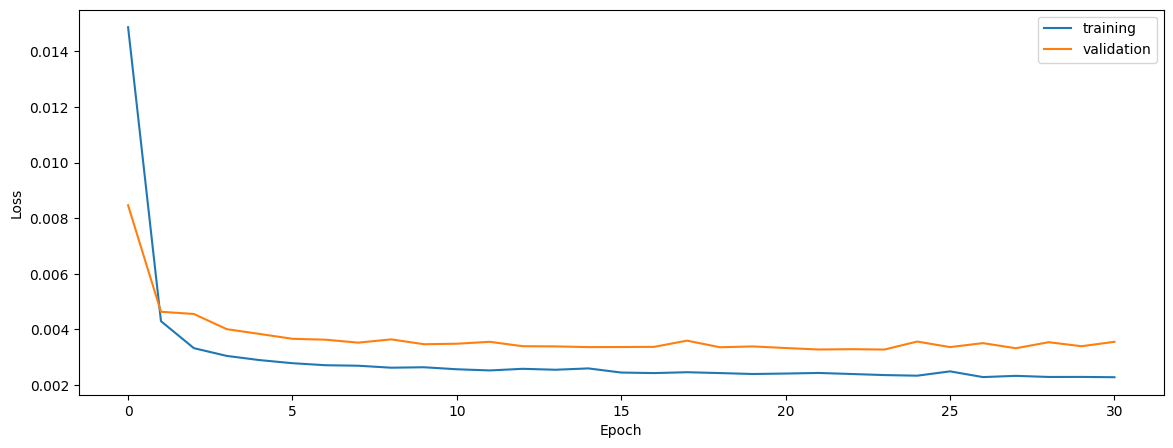

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


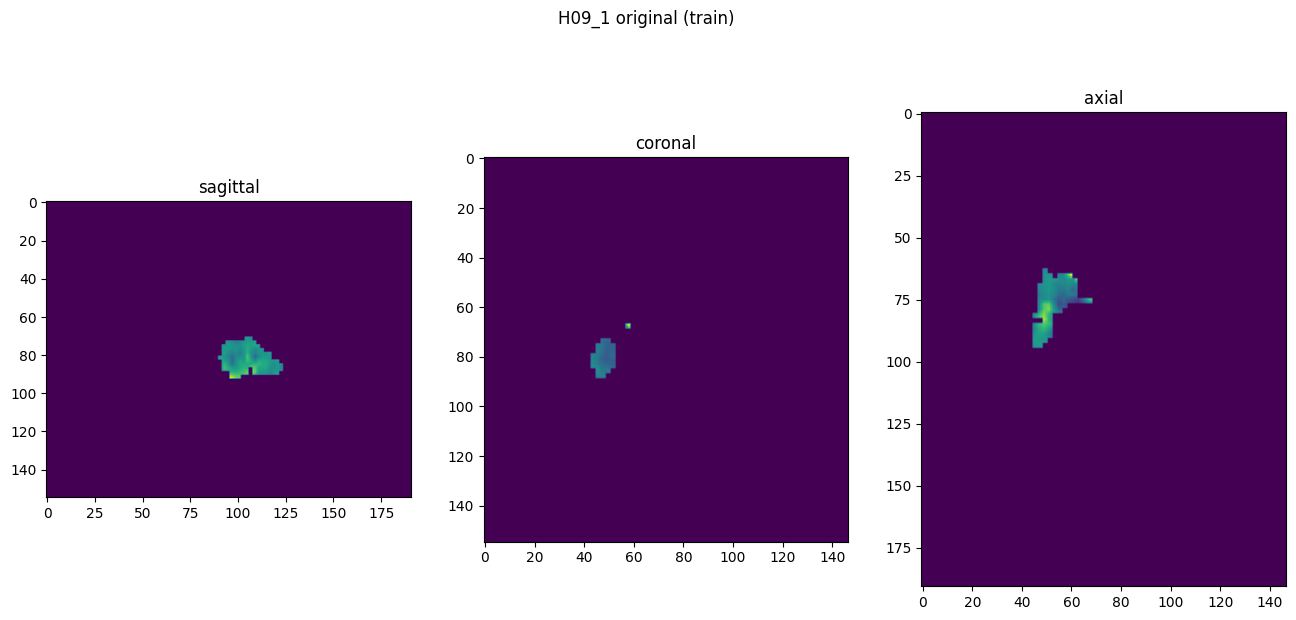

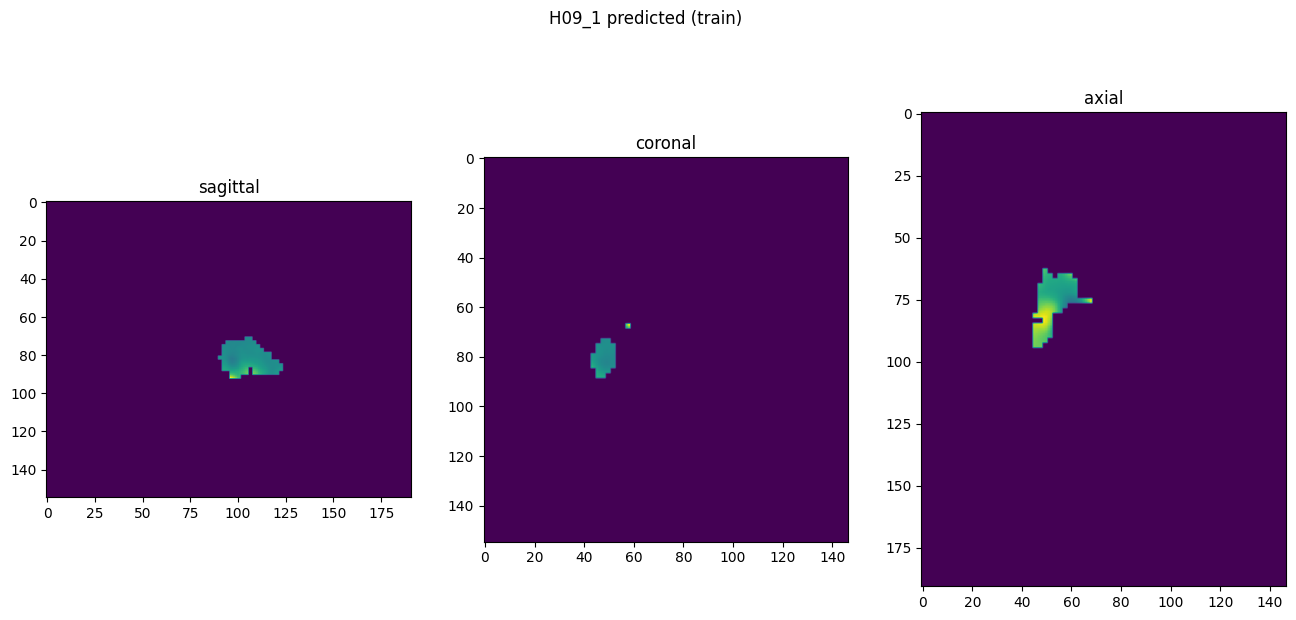

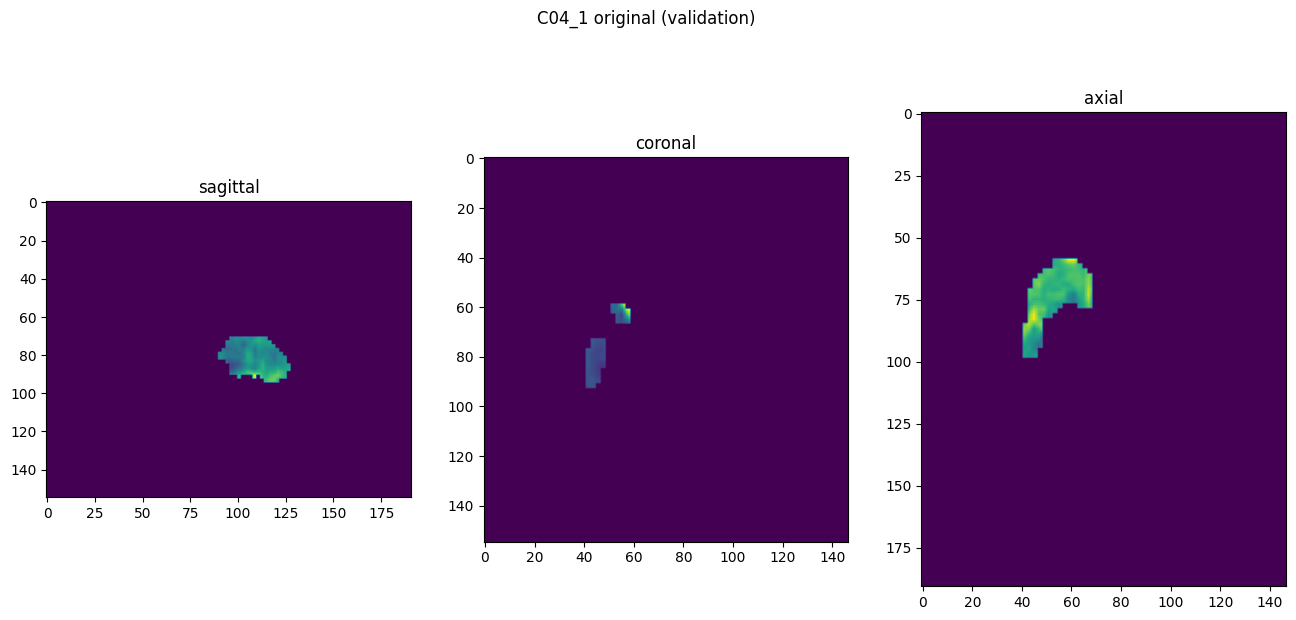

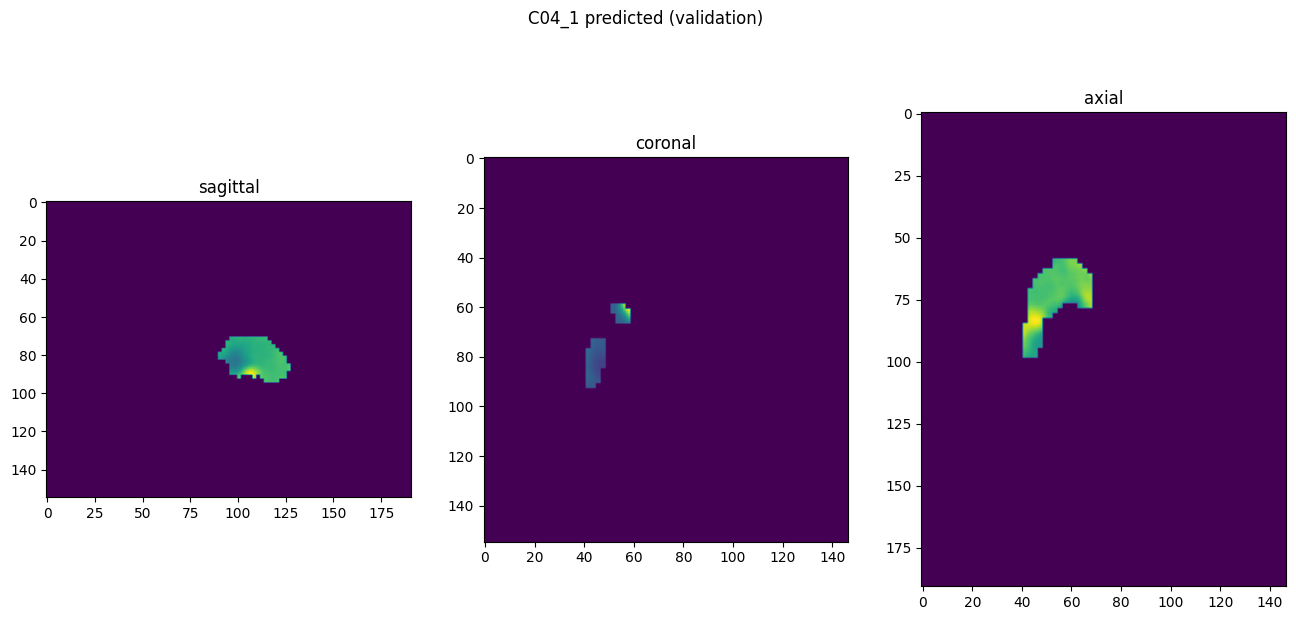

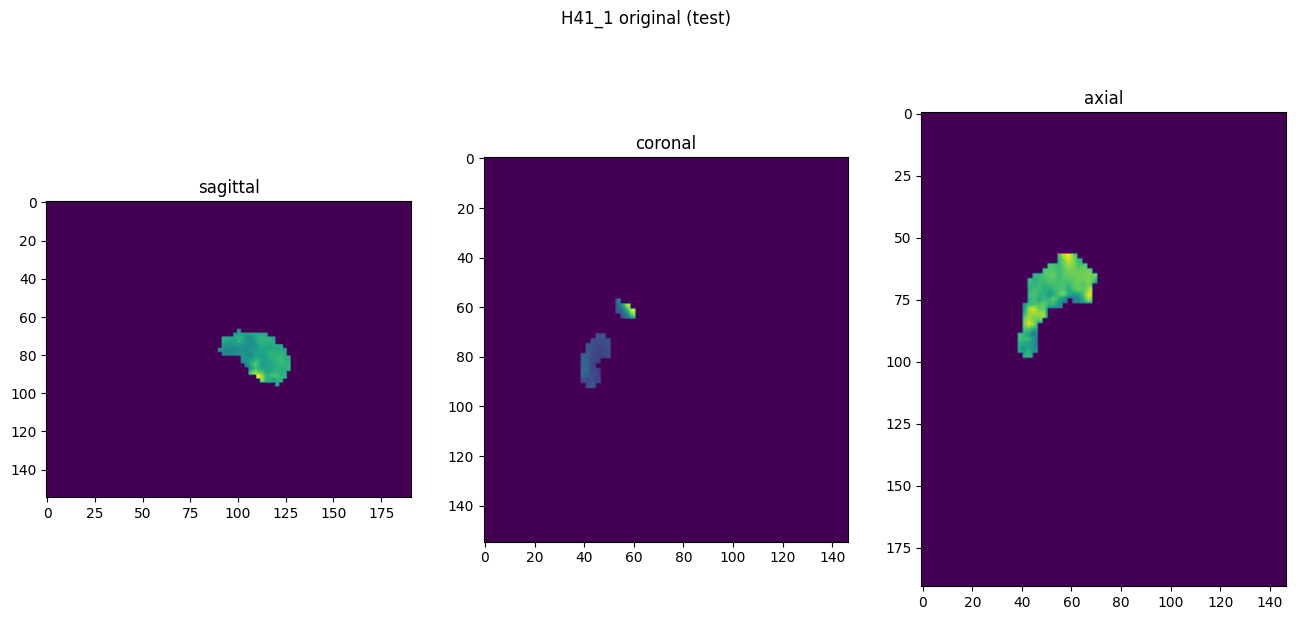

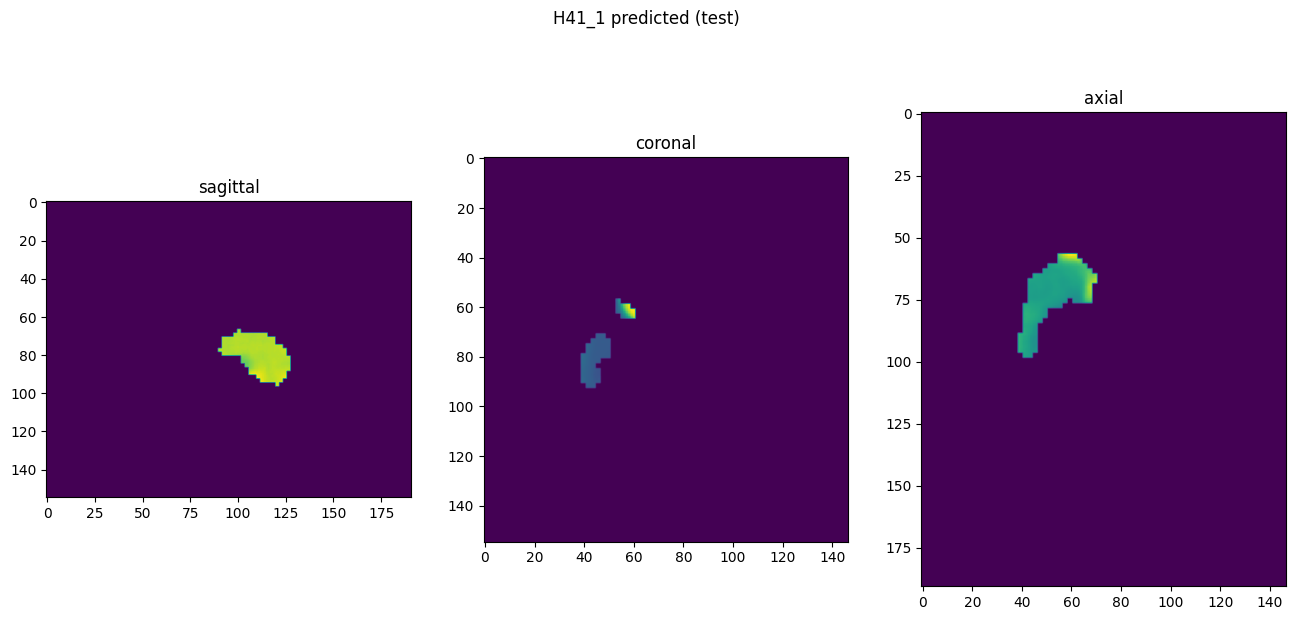

In [10]:
showResults(model, gen, threshold=None, background=False)